In [177]:
# math / stats
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data transform
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

# Model evaluation
from sklearn.metrics import recall_score, roc_auc_score, balanced_accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, f1_score

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Model optimization
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.pipeline import Pipeline as ImbPipeline  # Correct Pipeline

from imblearn.over_sampling import SMOTE

# Import Data

In [178]:
# Chargeons le fichier hmeq
file_path = 'hmeq.csv'
hmeq_data = pd.read_csv(file_path)

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [179]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Après importation des données, nous voyons que pour beaucoup de variables possèdent des valeurs manquantes.  
Il serait interessant de réaliser du pre-processing afin d'améliorer la qualité des données avant de réaliser une classification sur notre variable dépendante "BAD".  
  
Néanmoins, il serait pertinent d'analyser les performances d'un modèle le plus "simple", et l'utiliser en tant que benchmark.  
En effet, si après nettoyage de nos données, pour le même modèle, les résultats sont moins bons qu'une simple suppression des données manquantes, alors cela signifie que notre analyse est mauvaise.

# Analyse des variables

Commençons par séparer les données numériques des données catégoriques :

In [180]:
# Ensure 'BAD' is treated as a numerical column
hmeq_data["BAD"] = hmeq_data["BAD"].astype('int64')

# Separate categorical and numerical columns
categorical_cols = hmeq_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = hmeq_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols.append("BAD")

# Prepare datasets by dropping missing values
categorical_data = hmeq_data[categorical_cols]
numerical_data = hmeq_data[numerical_cols]


In [181]:
numerical_data.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [182]:
categorical_data.head()

,REASON,JOB,BAD
0,HomeImp,Other,1
1,HomeImp,Other,1
2,HomeImp,Other,1
3,NaN,NaN,1
4,HomeImp,Office,0


In [183]:
def plot_boxplot(df): # Configuration du layout des sous-graphiques
    num_plots = len(df.columns)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculer le nombre de lignes nécessaires
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

    # Aplatir les axes pour un accès facile
    axes = axes.flatten()

    # Itérer sur chaque variable et créer un boxplot personnalisé
    for i, var in enumerate(df.columns):
        ax = axes[i]
        
        # Boxplot pour la variable avec BAD comme axe des catégories
        sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
        
        # Titre et étiquettes
        ax.set_title(f"Boxplot de '{var}' par BAD")
        ax.set_xlabel("BAD (0 ou 1)")
        ax.set_ylabel(var)

    # Supprimer les axes inutilisés s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustement de l'affichage
    plt.tight_layout()
    plt.show()

In [184]:
def plot_histo(df):
    # Liste des variables numériques
    numeric_vars = df.columns

    # Configuration du layout des sous-graphiques
    num_plots = len(numeric_vars)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculer le nombre de lignes nécessaires
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

    # Aplatir les axes pour un accès facile
    axes = axes.flatten()

    # Itérer sur chaque variable numérique et créer un histogramme
    for i, var in enumerate(numeric_vars):
        axes[i].hist(df[var].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f"Distribution de '{var}'")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Fréquence")

    # Supprimer les axes inutilisés s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustement de l'affichage
    plt.tight_layout()
    plt.show()

## Variable dépendante (target)

Voyons la répartition des différentes valeurs de la variable "target" dans notre dataset.

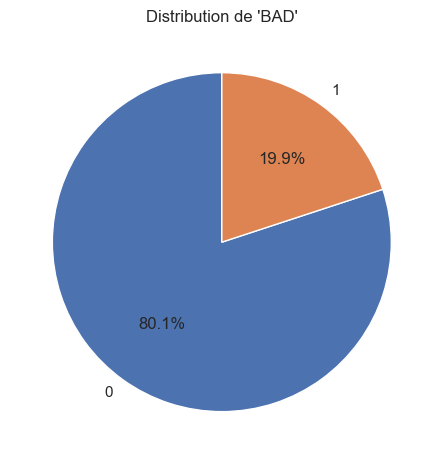

In [185]:
counts = hmeq_data['BAD'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f"Distribution de 'BAD'")

plt.tight_layout()
plt.show()

- 20% de BAD et 80% de non bad
- Si pre-processing par la suite, ne pas supprimer les lignes contenant BAD
- Pour le model, possiblement faire data augmentation pour augmenter la partie BAD (ou son importance), ou sous évaluer la partie non bad (poids moindre durant le training)

## Variables numériques

### Analyse de la distribution

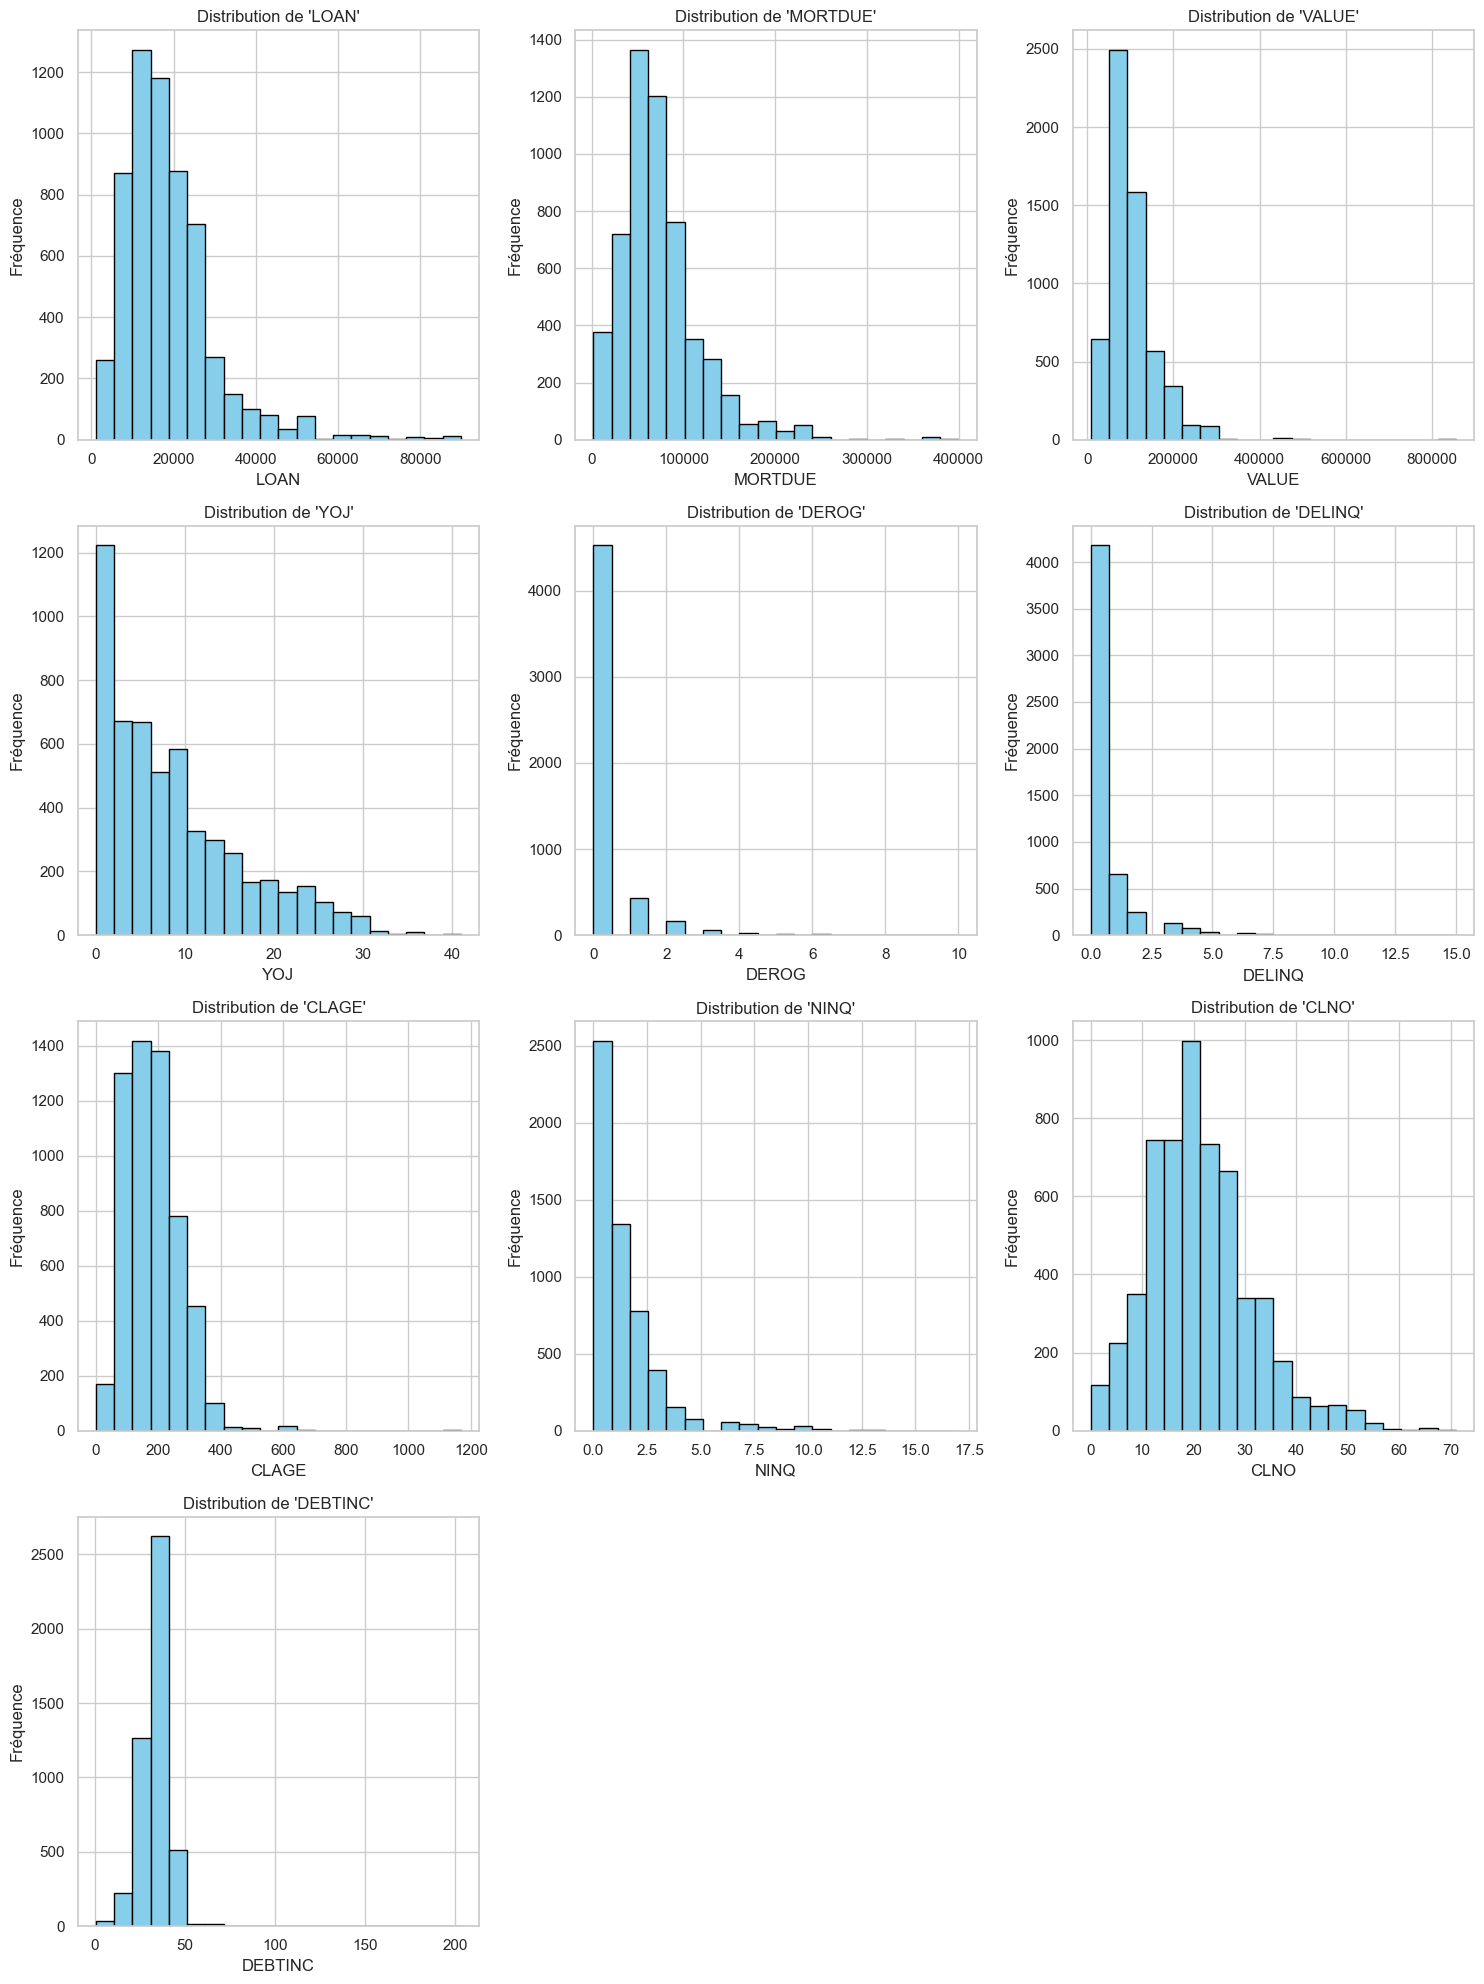

In [186]:
plot_histo(numerical_data.drop(['BAD'], axis=1))

- valeurs extrems ou aberrantes
- que faire ?

### Analyse des outliers

C:\Users\-\AppData\Local\Temp\ipykernel_67172\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
C:\Users\-\AppData\Local\Temp\ipykernel_67172\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
C:\Users\-\AppData\Local\Temp\ipykernel_67172\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BAD', y=va

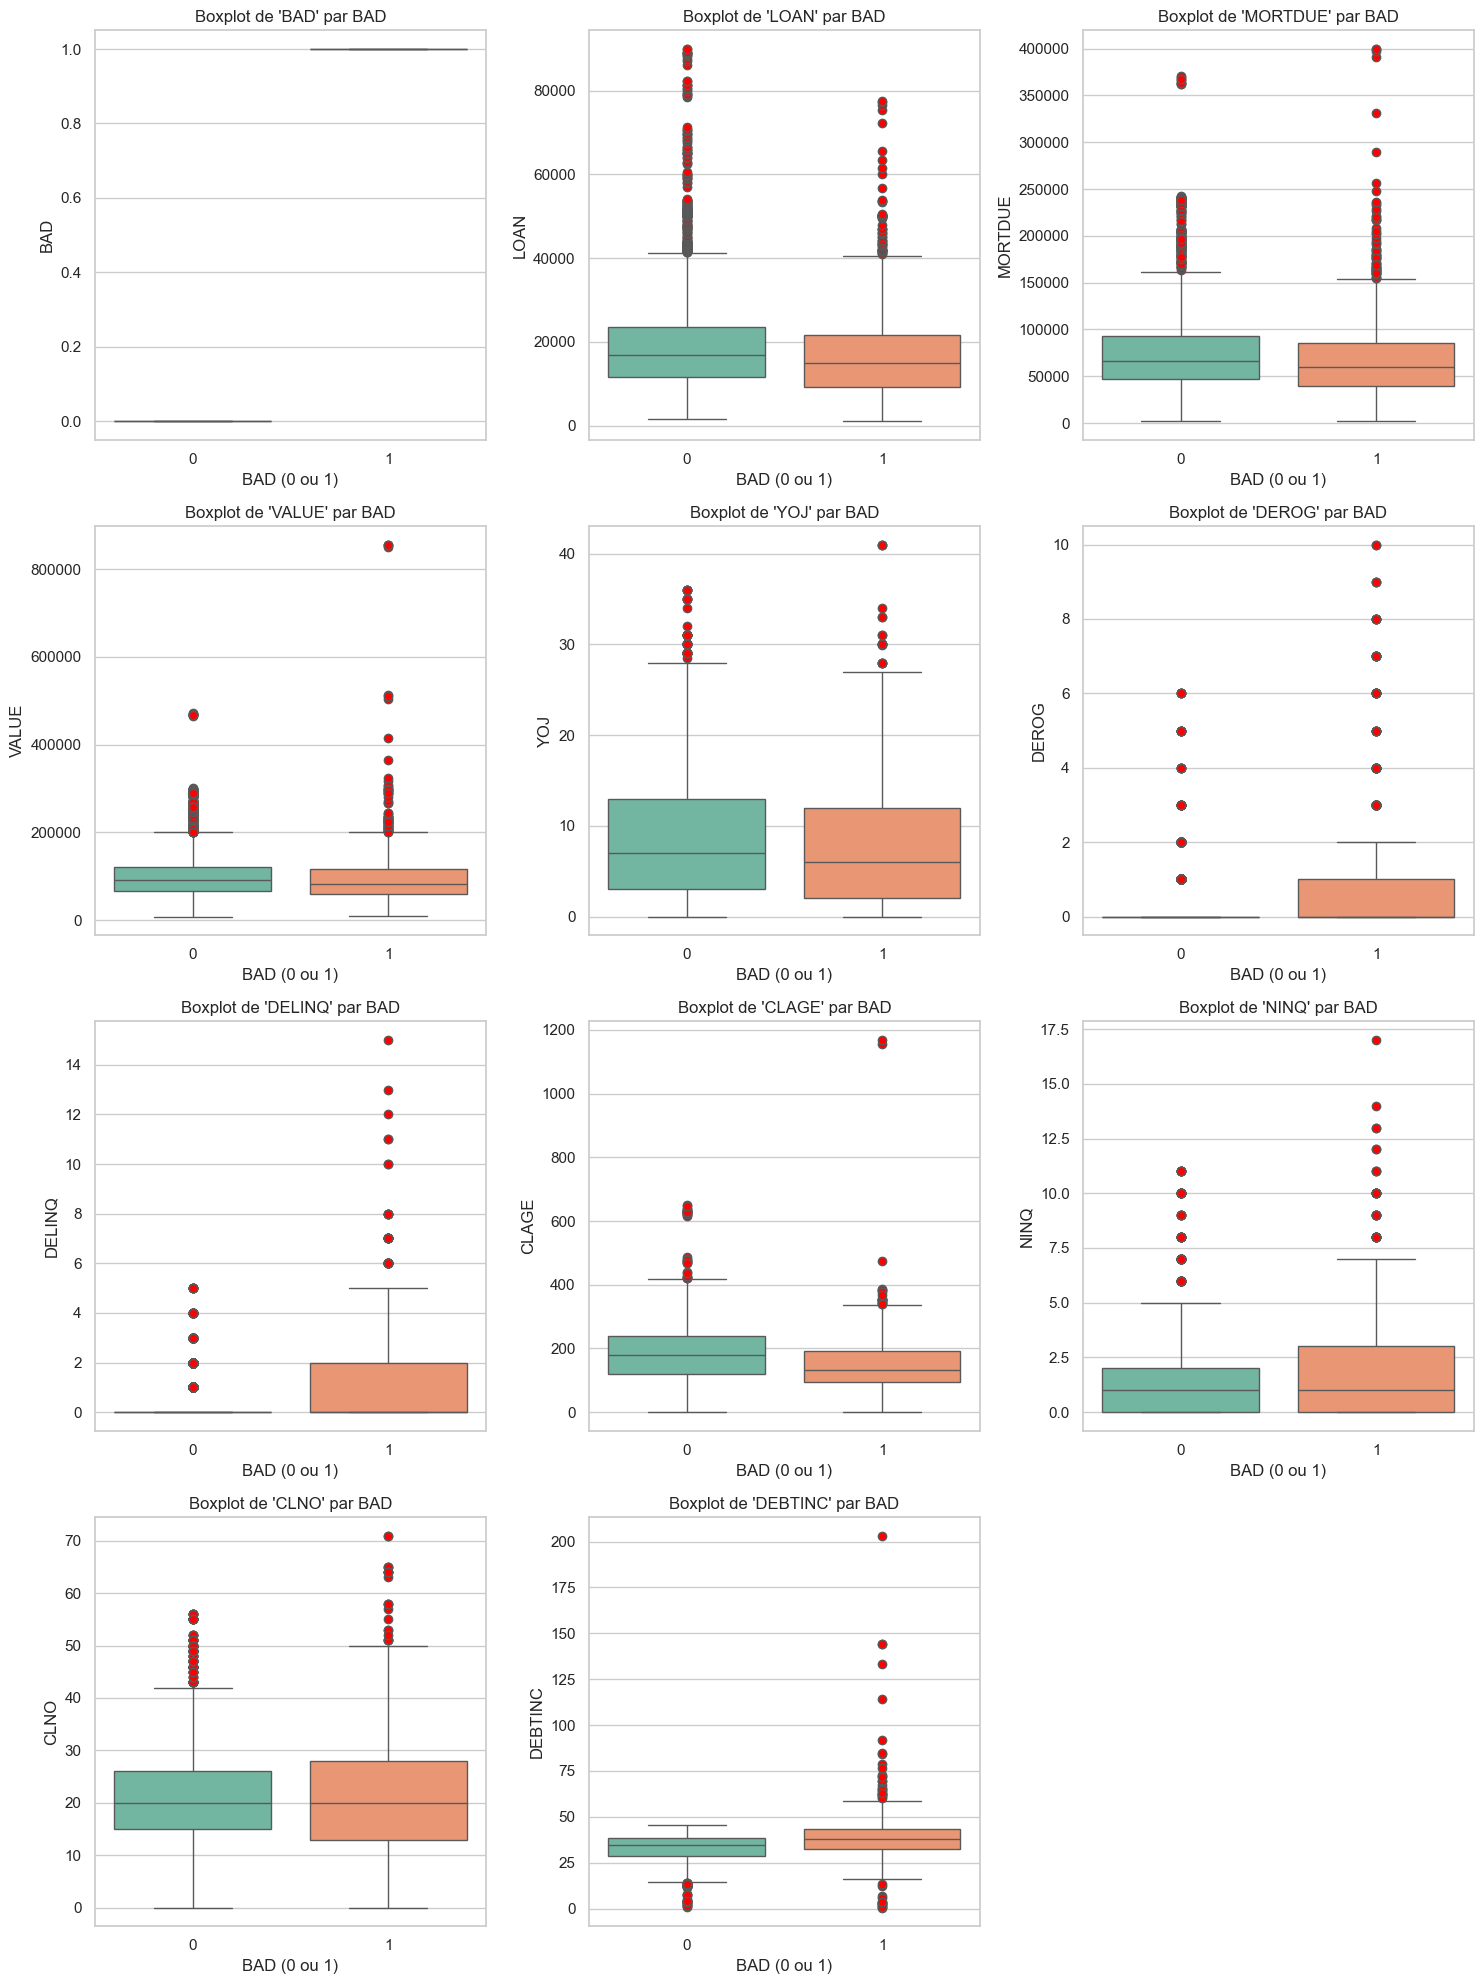

In [187]:
plot_boxplot(numerical_data)

- beaucoup de outliers
- mais outliers plus dans la classe 1 de "BAD" : ceux qui ont fait défaut

### NAN values

In [188]:
#Calculate null values and their percentages for the entire dataset
null_values_df = numerical_data.isnull().sum().reset_index()
null_values_df.columns = ['Column', 'Null_Count']
null_values_df['Overall_Percentage'] = (null_values_df['Null_Count'] / len(numerical_data)) * 100

#Separate data by class
class_0 = numerical_data[numerical_data['BAD'] == 0]
class_1 = numerical_data[numerical_data['BAD'] == 1]

#Calculate null percentages for each class
null_values_class_0 = class_0.isnull().sum().reset_index()
null_values_class_0.columns = ['Column', 'Class_0_Null_Count']
null_values_class_0['Class_0_Percentage'] = (null_values_class_0['Class_0_Null_Count'] / len(class_0)) * 100

null_values_class_1 = class_1.isnull().sum().reset_index()
null_values_class_1.columns = ['Column', 'Class_1_Null_Count']
null_values_class_1['Class_1_Percentage'] = (null_values_class_1['Class_1_Null_Count'] / len(class_1)) * 100

#Merge the results
null_values_df = pd.merge(null_values_df, null_values_class_0[['Column', 'Class_0_Null_Count', 'Class_0_Percentage']], on='Column')
null_values_df = pd.merge(null_values_df, null_values_class_1[['Column', 'Class_1_Null_Count', 'Class_1_Percentage']], on='Column')

#Filter only columns with null values
null_values_df = null_values_df[null_values_df['Null_Count'] > 0]

#Display the result
print(null_values_df)

     Column  Null_Count  Overall_Percentage  Class_0_Null_Count  \
2   MORTDUE         518            8.691275                 412   
3     VALUE         112            1.879195                   7   
4       YOJ         515            8.640940                 450   
5     DEROG         708           11.879195                 621   
6    DELINQ         580            9.731544                 508   
7     CLAGE         308            5.167785                 230   
8      NINQ         510            8.557047                 435   
9      CLNO         222            3.724832                 169   
10  DEBTINC        1267           21.258389                 481   

    Class_0_Percentage  Class_1_Null_Count  Class_1_Percentage  
2             8.635506                 106            8.915055  
3             0.146720                 105            8.830950  
4             9.431985                  65            5.466779  
5            13.016139                  87            7.317073  
6   

- Toutes les variables numériques ont entre 1 et 20% de valeurs manquantes.
- Si supprime ça fait bcp d'infos perdus
  
- De plus, 66% des valeurs null de la variable 'DEBTINC' sont de class_1 donc :

In [189]:
nb_approx_val_BAD_1 = (len(hmeq_data) * 0.2)
print(f"Nb NaN values dans colonne DEBTINC : {nb_approx_val_BAD_1}")
print(f"Nb observation BAD=1 après dropna de la colonne DEBTINC : {nb_approx_val_BAD_1 - null_values_class_1['Class_1_Null_Count'].iloc[-1]}")

Nb NaN values dans colonne DEBTINC : 1192.0
Nb observation BAD=1 après dropna de la colonne DEBTINC : 406.0


- Si on faisait bêtement un dropna(), on perderait bcp d'infos.
- 406 observations seulement...
- DONC pas de suppression, possiblement une imputation

Voyons dabord les variables catégorielles

## Variable catégorielle

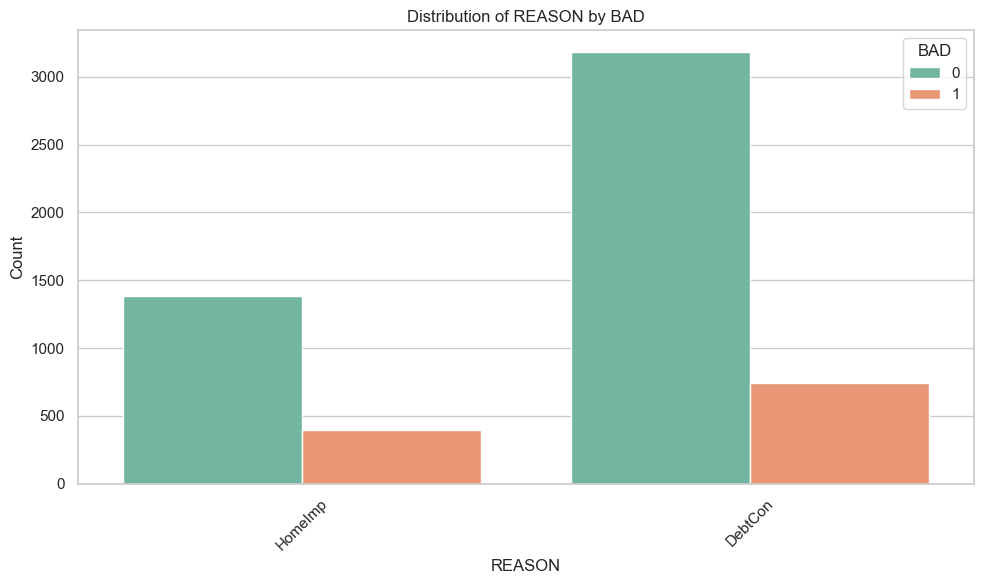

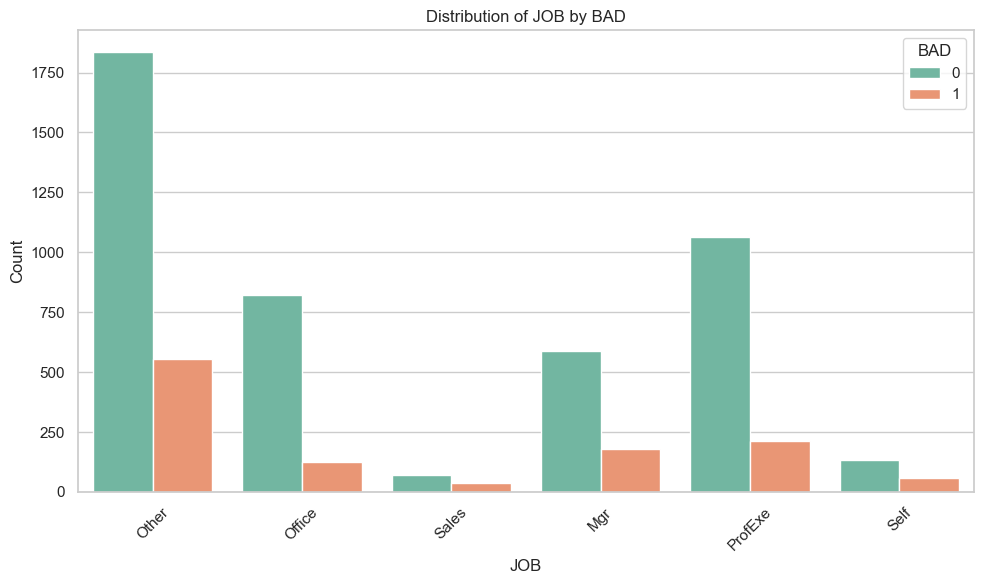

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_distributions(categorical_data, target_column="BAD"):
    """
    Visualizes categorical distributions and highlights outliers using proportions.
    
    Args:
        categorical_data (DataFrame): Data containing categorical features.
        target_column (str): The target variable (e.g., 'BAD').
    """
    for column in categorical_data.columns:
        if column != target_column:
            plt.figure(figsize=(10, 6))
            
            # Plot countplot with hue for the target column
            sns.countplot(data=categorical_data, x=column, hue=target_column, palette="Set2")
            plt.title(f"Distribution of {column} by {target_column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.legend(title=target_column)
            plt.tight_layout()
            plt.show()

# Call the function to plot categorical data distributions
plot_categorical_distributions(categorical_data)


Nous pouvons clairement voir que certaines catégories sont plus représentées que d'autres. Nous devons en tenir compte lors du traitement des valeurs manquantes.
Ainsi, lorsque nous traitons des valeurs aberrantes, nous devons être prudents lorsque nous abandonnons l'observation avec la raison DebtCon.

### NaN Values

In [191]:
#Initialize a dictionary to store the results
nan_analysis = []

#Loop through each variable
for col in ['REASON', 'JOB']:
    # Total NaN count and percentage for the column
    total_nan = hmeq_data[col].isnull().sum()
    total_nan_percentage = (total_nan / len(hmeq_data)) * 100

    # Count the total rows for each category
    category_counts = hmeq_data[col].value_counts(dropna=False)

    # Loop through categories (including NaN as a category)
    for category, total_count in category_counts.items():
        # Count rows where the value is NaN for this category
        nan_count = hmeq_data[(hmeq_data[col] == category) & (hmeq_data[col].isnull())].shape[0]

        # Calculate the percentage of NaNs for this category
        category_nan_percentage = (nan_count / total_count) * 100 if total_count > 0 else 0

        # Append results
        nan_analysis.append({
            'Variable': col,
            'Category': category if pd.notnull(category) else 'NaN',
            'Total_NaN_Percentage': total_nan_percentage,
            'Category_NaN_Percentage': category_nan_percentage
        })

#Convert results to a DataFrame
nan_analysis_df = pd.DataFrame(nan_analysis)

#Display the result
print(nan_analysis_df)

  Variable Category  Total_NaN_Percentage  Category_NaN_Percentage
0   REASON  DebtCon              4.228188                      0.0
1   REASON  HomeImp              4.228188                      0.0
2   REASON      NaN              4.228188                      0.0
3      JOB    Other              4.681208                      0.0
4      JOB  ProfExe              4.681208                      0.0
5      JOB   Office              4.681208                      0.0
6      JOB      Mgr              4.681208                      0.0
7      JOB      NaN              4.681208                      0.0
8      JOB     Self              4.681208                      0.0
9      JOB    Sales              4.681208                      0.0


- Observations

# Outliers treatment

Compte tenu des informations vu précémment :
- Bcp plus de BAD=0 que de BAD=1 (80% contre 20%)
- Outliers présents en grande majorité dans la classe 1 de BAD
- BCP de NaN values notemmant dans DEBTINC (700) mais 66% sont dans class 1 de BAD

DONC on les garde

# NaN Values Treatment

Nous avons vu q'il yavat :
- bcp de NaN values, il faut les supprimer ou les traiter
- d'une part pour les variables numériques et catégroielles

## NaN in numerical data

On choisit de visualier les imputations (MEAN, MEDIAN, KNN)

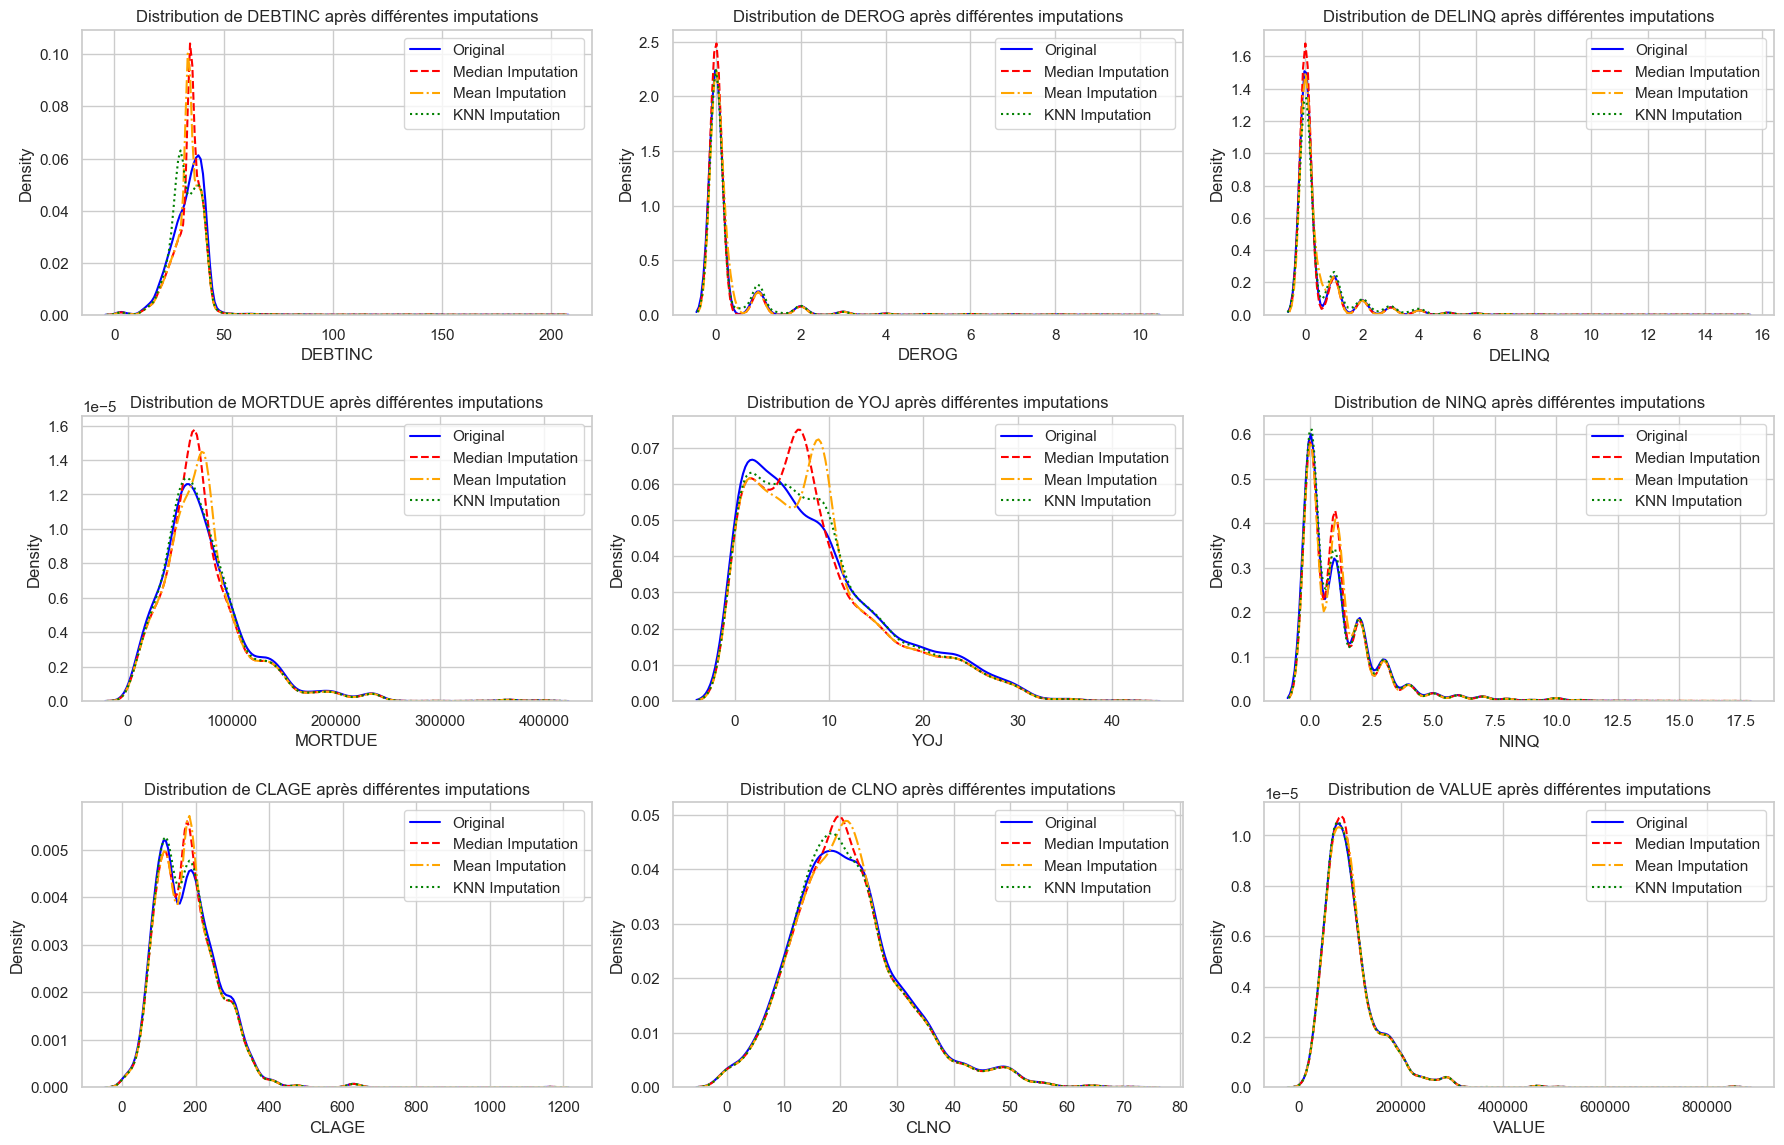

In [192]:
hmeq_data_original = hmeq_data.copy()

# Imputer les données manquantes numériques par la médiane
imputer_numeric = SimpleImputer(strategy='median')
hmeq_data_median_filled = hmeq_data_original.copy()  # Nouvelle base pour la médiane
hmeq_data_median_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_numeric.fit_transform(
    hmeq_data_median_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)


# Imputation par la moyenne
imputer_mean = SimpleImputer(strategy='mean')
hmeq_data_mean_filled = hmeq_data_original.copy()  # Nouvelle base pour la moyenne
hmeq_data_mean_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_mean.fit_transform(
    hmeq_data_mean_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)

# Imputation par KNN
imputer_knn = KNNImputer(n_neighbors=5)
hmeq_data_knn_filled = hmeq_data_original.copy()  # Nouvelle base pour KNN
hmeq_data_knn_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_knn.fit_transform(
    hmeq_data_knn_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)

plt.figure(figsize=(18, 15))
for i, col in enumerate(['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE'], 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(hmeq_data_original[col].dropna(), label='Original', color='blue', linestyle='-')
    sns.kdeplot(hmeq_data_median_filled[col], label='Median Imputation', color='red', linestyle='--')
    sns.kdeplot(hmeq_data_mean_filled[col], label='Mean Imputation', color='orange', linestyle='-.')
    sns.kdeplot(hmeq_data_knn_filled[col], label='KNN Imputation', color='green', linestyle=':')
    plt.title(f'Distribution de {col} après différentes imputations')
    plt.legend()

plt.tight_layout()
plt.show()

- Lequel est mieux?

Le graphique compare les méthodes d’imputation : médiane, moyenne et KNN. L’imputation par médiane est robuste aux outliers et conserve les distributions asymétriques (DEBTINC, DEROG), mais simplifie les données et lisse les distributions (CLAGE, YOJ).  
La moyenne, sensible aux outliers, déforme les distributions (MORTDUE, DEBTINC) et réduit la variabilité. KNN, en revanche, préserve mieux les distributions originales (YOJ, CLAGE, NINQ) en tenant compte des relations entre variables, mais est plus coûteux en calculs.

La méthode KNN est recommandée pour préserver la variabilité et les relations, avec l’imputation par médiane comme alternative en cas de fortes contraintes. La moyenne est la moins adaptée.

In [193]:
# Verify the results
print("Missing values after imputation:")
print(hmeq_data_knn_filled.isnull().sum())

Missing values after imputation:
BAD          0
LOAN         0
MORTDUE      0
VALUE        0
REASON     252
JOB        279
YOJ          0
DEROG        0
DELINQ       0
CLAGE        0
NINQ         0
CLNO         0
DEBTINC      0
dtype: int64


In [194]:
hmeq_data_knn_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


## NaN in catégorial data

Notre objectif :
- Combler les NaN values dans les variables catégorielles
- on peut
  - Remplacer par le mod
  - Drop les valeurs
- On va voir la distribution avant (avec les nan values)

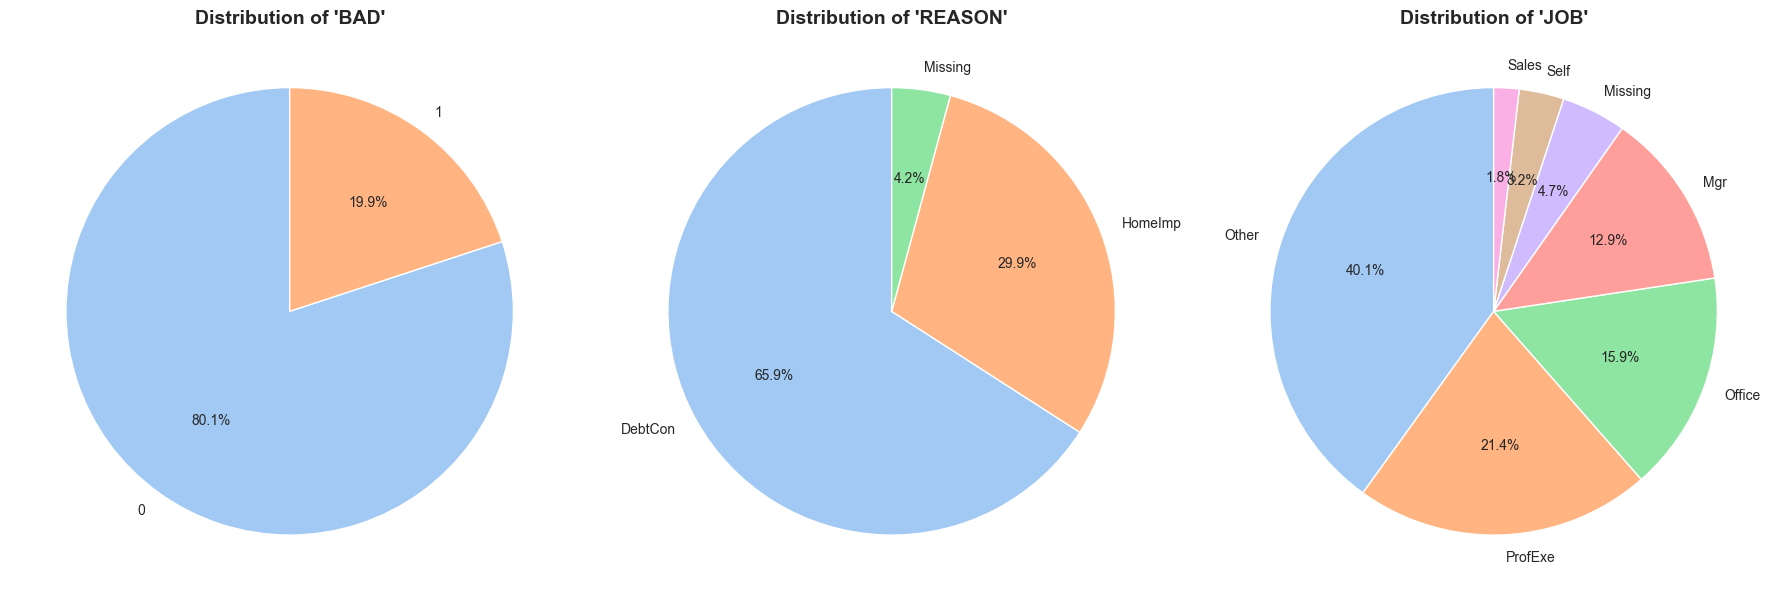

In [195]:
def plot_categorical_pie_charts_seaborn(data, categorical_vars, nan_class_label="Missing"):
    """
    Creates aesthetically pleasing pie charts for categorical variables using Seaborn styling,
    including NaNs as a separate class.

    Args:
        data (pd.DataFrame): The dataset containing categorical variables.
        categorical_vars (list): List of categorical variable names.
        nan_class_label (str): Label to use for missing values in the pie chart.
    """
    sns.set_theme(style="whitegrid")  # Set Seaborn theme
    num_vars = len(categorical_vars)
    fig, axes = plt.subplots(1, num_vars, figsize=(6 * num_vars, 6), subplot_kw={'aspect': 'equal'})

    # Ensure axes is iterable for a single plot case
    axes = axes.flatten() if num_vars > 1 else [axes]

    for i, var in enumerate(categorical_vars):
        # Include NaNs as a separate class
        counts = data[var].value_counts(dropna=False)
        labels = counts.index.to_list()
        labels = [str(label) if pd.notna(label) else nan_class_label for label in labels]

#Seaborn color palette
        colors = sns.color_palette("pastel", len(labels))

#Create pie chart
        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 10}
        )

#Add a title
        axes[i].set_title(f"Distribution of '{var}'", fontsize=14, fontweight='bold')

#Adjust layout for better visuals
    plt.tight_layout()
    plt.show()

#Define categorical variables
categorical_vars = ['BAD', 'REASON', 'JOB']

#Call the function
plot_categorical_pie_charts_seaborn(hmeq_data, categorical_vars)

Il n'y a que 5% pour les 2 variables catégoriques "REASON" et "JOB", on peut donc les supprimer au lieu d'essayer d'estimer et biaisé les données.

In [196]:
# Copy the original data
hmeq_data_processed = hmeq_data_knn_filled.copy()

hmeq_data_processed.dropna(inplace=True)

# Impute missing values for categorical columns using mode
# mode_imputer = SimpleImputer(strategy='most_frequent')
# hmeq_data_processed[categorical_cols] = mode_imputer.fit_transform(hmeq_data_processed[categorical_cols])

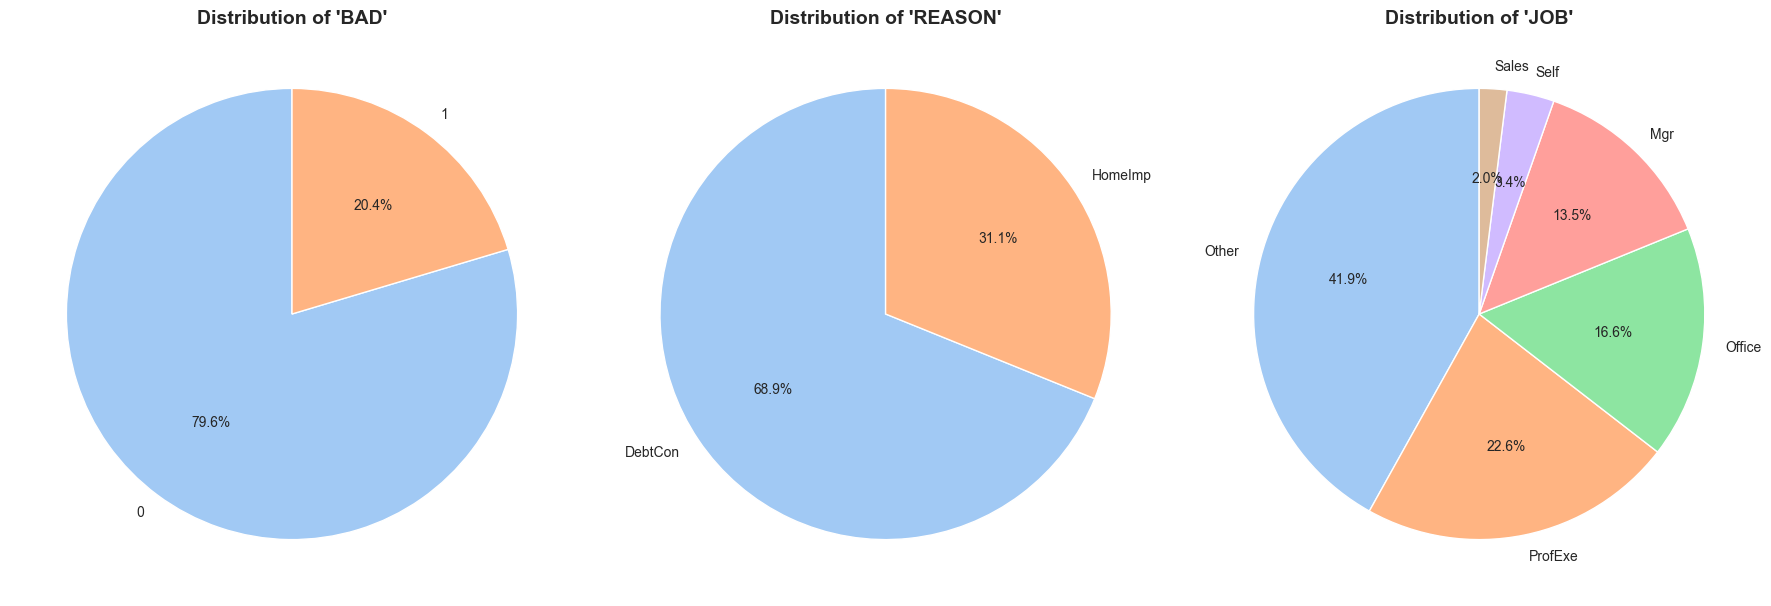

In [197]:
plot_categorical_pie_charts_seaborn(hmeq_data_processed, categorical_vars)

In [198]:
# Verify the results
print("Missing values after imputation:")
print(hmeq_data_processed.isnull().sum())

Missing values after imputation:
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


In [199]:
print(len(hmeq_data_processed))

5536


Nous avons traité toutes les valeurs manquantes, que ce soit pour les variables numériques ou les valeurs catégorielles.

# Features selection

## Relation Numérique-Catégorielle

In [200]:
def print_anova(df, category):
    res_tab = []
    
    print(f"ANOVA: BAD -- {numerical_cols[1:]}")
    for col in numerical_cols[1:len(numerical_cols)]:
        grouped_data = [df[df[category] == cat][col] for cat in df[category].unique()]

        # Effectuer le test ANOVA
        f_stat, p_value = f_oneway(*grouped_data)

        res_tab.append({
            "category": col,
            "Statistique F": f_stat,
            "p-value": p_value
        })
    print(pd.DataFrame(res_tab).set_index('category'))

In [201]:
print_anova(hmeq_data_processed, "BAD")

ANOVA: BAD -- ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
          Statistique F        p-value
category                              
LOAN          43.611845   4.378365e-11
MORTDUE       17.076157   3.644049e-05
VALUE         10.871724   9.825956e-04
YOJ           18.897293   1.404214e-05
DEROG        353.028728   2.122770e-76
DELINQ       535.215315  4.154174e-113
CLAGE        160.290070   3.097457e-36
NINQ         143.507562   1.150785e-32
CLNO           2.590909   1.075357e-01
DEBTINC        0.217749   6.407790e-01


In [202]:
print_anova(hmeq_data_processed, "REASON")

ANOVA: BAD -- ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
          Statistique F       p-value
category                             
LOAN         220.022855  7.676688e-49
MORTDUE        3.940703  4.718037e-02
VALUE          0.049699  8.235966e-01
YOJ            8.628049  3.323912e-03
DEROG          0.259545  6.104531e-01
DELINQ         0.019171  8.898837e-01
CLAGE         17.066607  3.662364e-05
NINQ          85.732884  2.882932e-20
CLNO          67.950096  2.074828e-16
DEBTINC       16.306545  5.460600e-05


In [203]:
print_anova(hmeq_data_processed, "JOB")

ANOVA: BAD -- ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
          Statistique F        p-value
category                              
LOAN          34.799015   3.739921e-35
MORTDUE      145.205453  3.215463e-145
VALUE        155.253471  8.721617e-155
YOJ            5.213621   8.868356e-05
DEROG         10.110592   1.182336e-09
DELINQ         3.898005   1.576734e-03
CLAGE         17.664609   2.094142e-17
NINQ          18.499666   2.870034e-18
CLNO          52.287145   3.606392e-53
DEBTINC        9.346253   7.025455e-09


## Relation Catégorielle-Catégorielle

Testons les relations d'indépendances entre les valeurs catégorielles :  
H0 : var_x est indépendante de var_y  
H1 : var_x est dépendante de var_y

In [204]:
def plot_contingency_table(df, x_name, y_name):
  # Création d'un tableau de contingence entre x_name et y_name
  contingency_table_observed = pd.crosstab(df[x_name], df[y_name])

  # Test du Khi²
  chi2_stat, p_value, dof, contingency_table_expected = chi2_contingency(contingency_table_observed)

  df[y_name].unique()

  # Résultats
  print("Statistique Khi² :", chi2_stat)
  print("Valeur p :", p_value)
  print("Degrés de liberté :", dof)
  print("\nEffectifs attendus :\n", pd.DataFrame(contingency_table_expected, columns=df[y_name].unique()).rename_axis(x_name))
  print("\nEffectifs observés :")
  print(contingency_table_observed)
  
  fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

  # Graphique pour les effectifs observés
  axes[0].bar(contingency_table_observed.columns, contingency_table_observed.values[0], label=f"{x_name}={df[x_name].unique()[0]} (Observé)", color='skyblue', alpha=0.8)
  axes[0].bar(contingency_table_observed.columns, contingency_table_observed.values[1], label=f"{x_name}={df[x_name].unique()[1]} (Observé)", bottom=contingency_table_observed.values[0], color='orange', alpha=0.8)
  axes[0].set_title("Effectifs Observés")
  axes[0].set_ylabel("Nombre d'individus")
  axes[0].set_xlabel(y_name)
  axes[0].legend()

  # Graphique pour les effectifs attendus
  axes[1].bar(contingency_table_observed.columns, contingency_table_expected[0], label=f"{x_name}={df[x_name].unique()[0]} (Attendu)", color='blue', alpha=0.5)
  axes[1].bar(contingency_table_observed.columns, contingency_table_expected[1], label=f"{x_name}={df[x_name].unique()[1]} (Attendu)", bottom=contingency_table_expected[0], color='red', alpha=0.5)
  axes[1].set_title("Effectifs Attendus")
  axes[1].set_xlabel("REASON")
  axes[1].legend()

  # Affichage
  plt.tight_layout()
  plt.show()

Statistique Khi² : 8.488158442132361
Valeur p : 0.003574654537949155
Degrés de liberté : 1

Effectifs attendus :
          HomeImp      DebtCon
BAD                          
0    3036.073699  1371.926301
1     776.926301   351.073699

Effectifs observés :
REASON  DebtCon  HomeImp
BAD                     
0          3077     1331
1           736      392


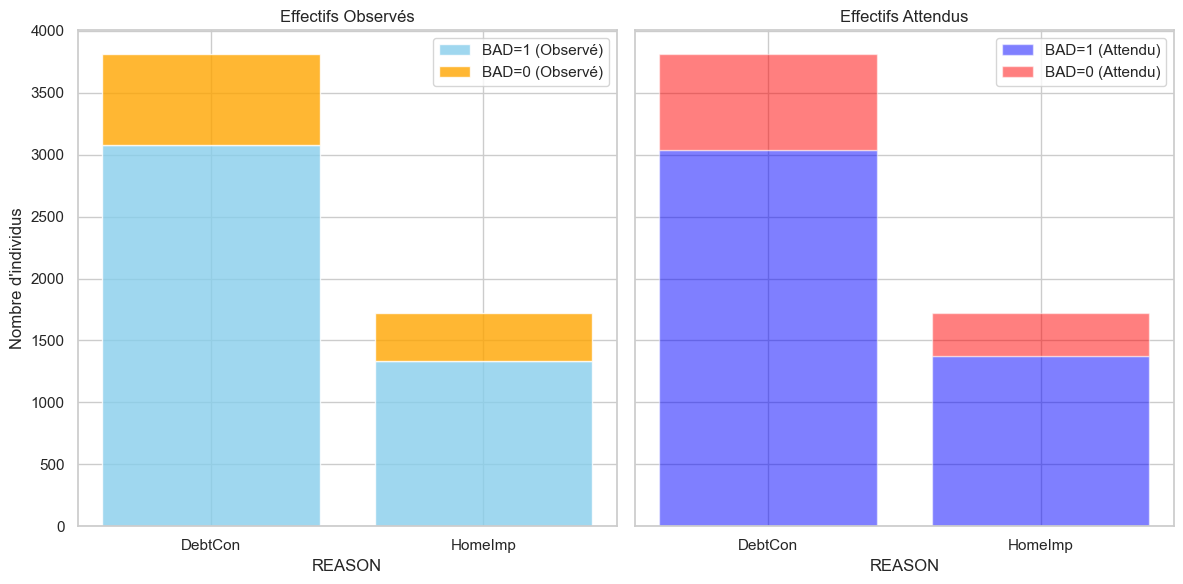

In [205]:
plot_contingency_table(hmeq_data_processed, 'BAD', 'REASON')

- On voit que l'effectif attendu est quasi égale à l'effectif expected
- et on a une p-value < 1%
- donc on rejette H0 au seuil de 1%, donc indépendance entre 'BAD' et 'REASON'

Statistique Khi² : 75.96474145927391
Valeur p : 5.851112295966899e-15
Degrés de liberté : 5

Effectifs attendus :
          Other      Office        Sales         Mgr    ProfExe        Self
BAD                                                                       
0    593.99711  733.339595  1847.283237  996.895954  86.790462  149.693642
1    152.00289  187.660405   472.716763  255.104046  22.209538   38.306358

Effectifs observés :
JOB  Mgr  Office  Other  ProfExe  Sales  Self
BAD                                          
0    574     796   1782     1050     71   135
1    172     125    538      202     38    53


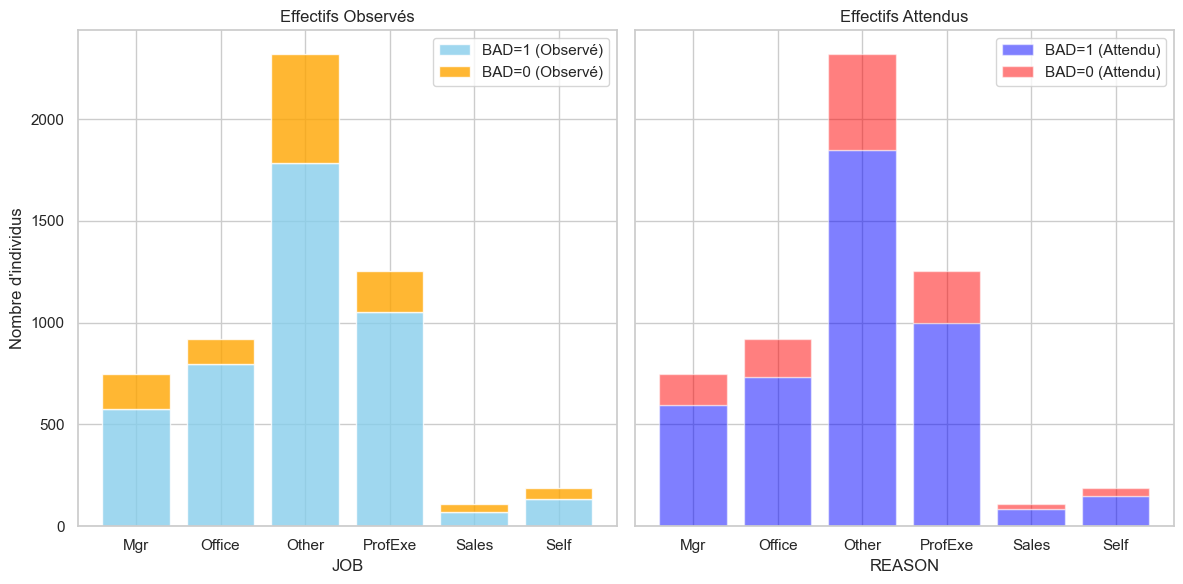

In [206]:
plot_contingency_table(hmeq_data_processed, 'BAD', 'JOB')

In [207]:
# Création d'un tableau de contingence entre deux variables catégorielles, par exemple 'REASON' et 'JOB'
contingency_table = pd.crosstab(hmeq_data_processed['REASON'], hmeq_data_processed['JOB'])

# Application du test Khi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats
print(f"Valeur p du test Khi² : {p_value}")

# Résultats
print("Statistique Khi² :", chi2_stat)
print("Valeur p :", p_value)
print("Degrés de liberté :", dof)
print("\nEffectifs attendus :\n", pd.DataFrame(expected, columns=hmeq_data_processed["JOB"].unique()).rename_axis("REASON"))
print("\nEffectifs observés :")
print(contingency_table)

# Interprétation de la valeur p
if p_value < 0.05:
    print("On rejette H0 : Il existe une relation significative entre REASON et JOB")
else:
    print("On ne rejette pas H0 : REASON et JOB sont indépendants")

Valeur p du test Khi² : 7.594351096848582e-25
Statistique Khi² : 122.90857547157839
Valeur p : 7.594351096848582e-25
Degrés de liberté : 5

Effectifs attendus :
             Other      Office        Sales         Mgr    ProfExe        Self
REASON                                                                       
0       513.81828  634.352059  1597.933526  862.333092  75.075325  129.487717
1       232.18172  286.647941   722.066474  389.666908  33.924675   58.512283

Effectifs observés :
JOB      Mgr  Office  Other  ProfExe  Sales  Self
REASON                                           
DebtCon  572     620   1604      847     97    73
HomeImp  174     301    716      405     12   115
On rejette H0 : Il existe une relation significative entre REASON et JOB


In [208]:
def chi_square_analysis(data, var1, var2):
    # Create a contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])

    # Perform Chi-Square test
    chi2_stat, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Calculate Cramér's V
    n = contingency_table.values.sum()
    cramer_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))

    return {
      "Chi2 Statistic": chi2_stat,
      "p-value": p,
      "Degrees of Freedom": dof,
      "Cramér's V": cramer_v
    }

# Example usage
results = chi_square_analysis(hmeq_data_processed, 'REASON', 'JOB')
print("Chi2 Statistic:", results["Chi2 Statistic"])
print("p-value:", results["p-value"])
print("Cramér's V:", results["Cramér's V"])

Chi2 Statistic: 122.90857547157839
p-value: 7.594351096848582e-25
Cramér's V: 0.1490023273179537


Pour interpréter les valeurs du V de Cramér :
- 0.0 - 0.1 : Très faible association, les variables sont presque indépendantes.
- 0.1 - 0.3 : Faible association.
- 0.3 - 0.5 : Moyenne association.
- 0.5 - 0.7 : Forte association.
- 0.7 - 1.0 : Très forte association.
  
Finalement, avec le test de Chi2, on a vu que les deux variables explicatives catégorielles "REASON" et "JOB" sont dépendantes. De plus, lorsqu'on vérifie la force de l'association entre ces 2 variables avec le V de Cramér, nous n'avons qu'une valeur de 0.14, correspondant donc a une association faible.   
  
Compte tenu la force de rejet de H0 dans le test de significativité d'indépendance entre "BAD" <- "JOB" et "BAD" <- "REASON", "JOB" a été rejeté avec beaucoup plus de confiance que la variable "RAISON". On peut donc supprimer la variable "REASON".  
Car possiblement, elle pourrait avoir moins de lien de prédiction à BAD que "JOB".

In [209]:
hmeq_data_processed.drop(['REASON'], axis=1, inplace=True)
categorical_cols.remove("REASON")

## Relation numérique-numérique

La corrélation nécessite des données complètes :

Une matrice de corrélation ne peut pas traiter les valeurs NaN car les valeurs manquantes entraînent des relations non définies entre les variables.
Impact sur les relations entre les variables :

Les données manquantes peuvent fausser la matrice de corrélation, en particulier si les données manquantes ne sont pas aléatoires ou si elles sont présentes dans des caractéristiques critiques.  
C'est pourquoi nous avons traité dabord les NaN/missings values.

In [210]:
def plot_corr_matrix(df, cols):
  # Calcul de la matrice de corrélation avec la méthode Spearman
  spearman_corr_matrix = df[cols].corr(method='spearman')

  # Afficher la matrice de corrélation sous forme de heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(spearman_corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
  plt.title('Matrice de corrélation (Spearman)')
  plt.show()

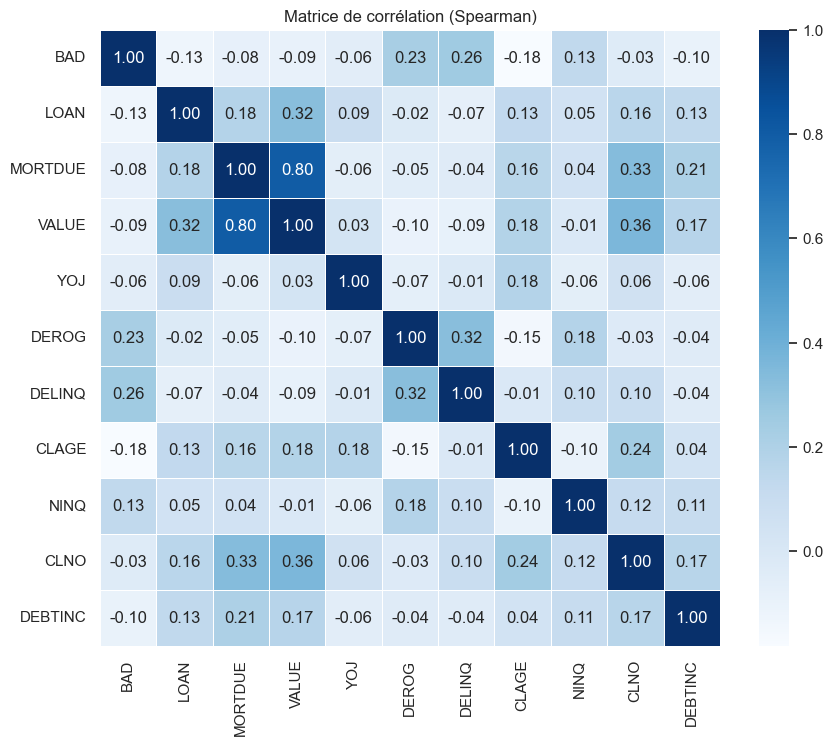

In [211]:
plot_corr_matrix(hmeq_data_processed, numerical_cols)

Forte corrélation entre les variables :

MORTDUE et VALEUR : forte corrélation positive (~0,79), suggérant une possible multicolinéarité.
CLNO et VALUE : corrélation modérée (~0,36).
CLNO et MORTDUE : corrélation modérée (~0,33).
Faible corrélation avec la cible (BAD) :

La plupart des caractéristiques ont une faible corrélation avec BAD, ce qui implique qu'elles n'influencent pas fortement la cible directement.

Mais la matrice de corrélation ne représente que les relations linéaires entre les variables. Peut être qu'il existe des relations plus complexes que nous ne percevons pas ?  
Voyons, avec le VIF pour confirmer :

In [212]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for numerical features
vif = calculate_vif(hmeq_data_processed[numerical_cols].drop(['BAD'], axis=1))
print(vif)

   Feature        VIF
0     LOAN   4.378341
1  MORTDUE  10.881209
2    VALUE  11.649388
3      YOJ   2.578813
4    DEROG   1.194132
5   DELINQ   1.296223
6    CLAGE   5.665028
7     NINQ   1.565655
8     CLNO   6.614786
9  DEBTINC   8.910296


Le VIF nous confirme que MORTDUE et VALUE ont une value élevé.  
Au niveau de leur corrélation avec BAD, c'est équivalent (cor(MORTDUE, BAD) = cor(VALUE, BAD)).  
On choisit de supprimer VALUE qui a le VIF le plus élevé.

In [213]:
hmeq_data_processed_features_selected = hmeq_data_processed.drop(['VALUE'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,27.351325
1,1,1300,70053.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,29.764339
2,1,1500,13500.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,28.138068
4,0,1700,97800.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,30.898685
5,1,1700,30548.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614


Réitérons ce process.

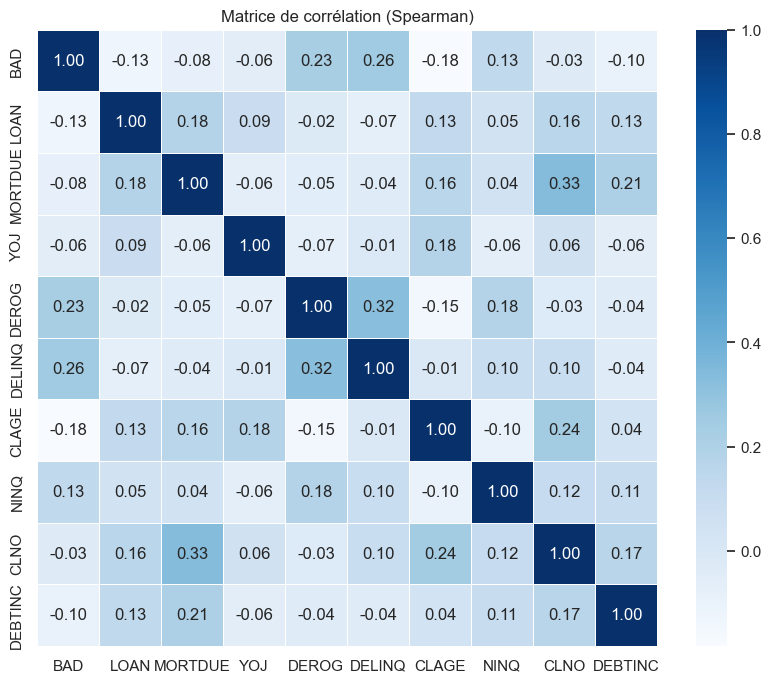

In [214]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('VALUE')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [215]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  4.101998
1  MORTDUE  4.639834
2      YOJ  2.546118
3    DEROG  1.194039
4   DELINQ  1.294161
5    CLAGE  5.654154
6     NINQ  1.562427
7     CLNO  6.611359
8  DEBTINC  8.894573


Corrélation avec d'autres caractéristiques financières :  
Des variables telles que LOAN, MORTDUE ou CLNO peuvent affecter indirectement DEBTINC.  
  
Par exemple :  
PRÊT : Des prêts plus importants augmentent généralement la dette totale, ce qui influence le ratio dette/revenu.  
MORTDUE : L'encours des prêts hypothécaires contribue de manière significative à l'endettement total.  
CLNO (Nombre de lignes de crédit) : Un nombre plus élevé de lignes de crédit peut indiquer un endettement plus important, ce qui a un impact sur le rapport dette/revenu.  
  
Il est donc possible de supprimer DEBTINC

In [216]:
hmeq_data_processed_features_selected = hmeq_data_processed_features_selected.drop(['DEBTINC'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0
1,1,1300,70053.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0
2,1,1500,13500.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0
4,0,1700,97800.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0
5,1,1700,30548.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0


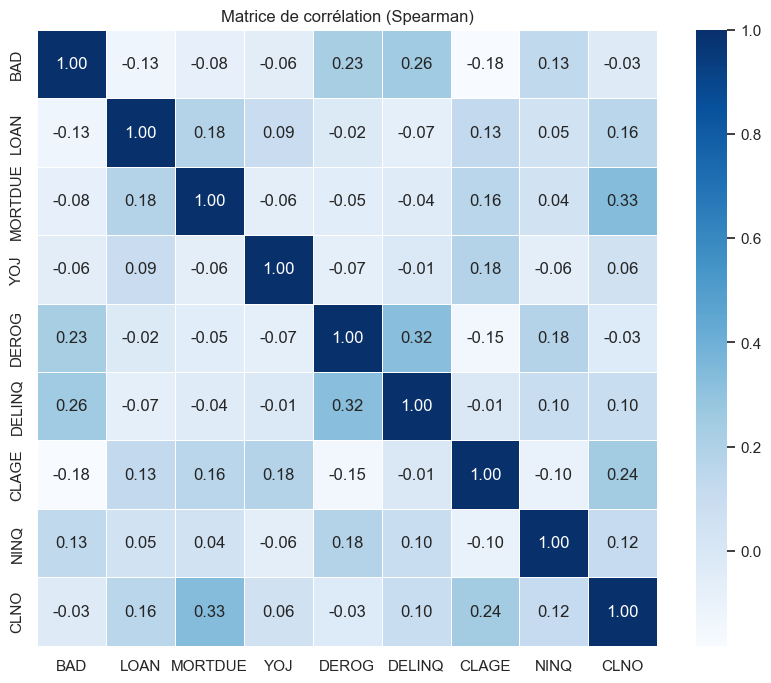

In [217]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('DEBTINC')
tmp_cols.remove('VALUE')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [218]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  3.774487
1  MORTDUE  4.360917
2      YOJ  2.472780
3    DEROG  1.188092
4   DELINQ  1.293412
5    CLAGE  5.205187
6     NINQ  1.509037
7     CLNO  5.909897


L'indicateur VIF pour le CLAGE et le CLNO est supérieur à 5, ce qui peut s'expliquer logiquement compte tenu de la nature des deux variables. Nous décidons de conserver CLAGE et d'abandonner CLNO car la première est plus corrélée à la caractéristique cible.  
- MAIS comme CLNO est moins corrélé avec BAD, on va supprimer CLNO

In [219]:
hmeq_data_processed_features_selected = hmeq_data_processed_features_selected.drop(['CLNO'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ
0,1,1100,25860.0,Other,10.5,0.0,0.0,94.366667,1.0
1,1,1300,70053.0,Other,7.0,0.0,2.0,121.833333,0.0
2,1,1500,13500.0,Other,4.0,0.0,0.0,149.466667,1.0
4,0,1700,97800.0,Office,3.0,0.0,0.0,93.333333,0.0
5,1,1700,30548.0,Other,9.0,0.0,0.0,101.466002,1.0


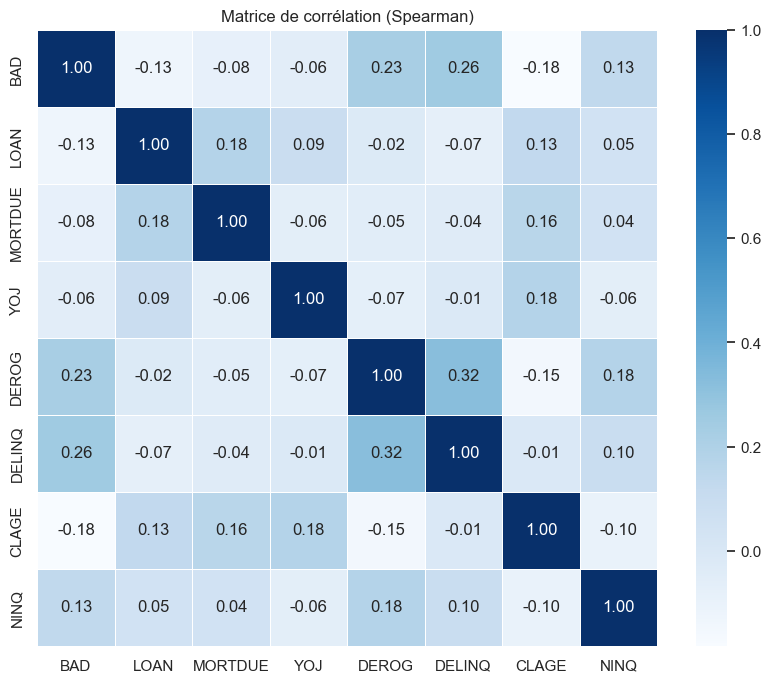

In [220]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('DEBTINC')
tmp_cols.remove('VALUE')
tmp_cols.remove('CLNO')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [221]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  3.723902
1  MORTDUE  3.643620
2      YOJ  2.429287
3    DEROG  1.182287
4   DELINQ  1.253856
5    CLAGE  4.412798
6     NINQ  1.476220


La matrice de corr est ok et le VIF OK (- de 5). DONC C'est bon.

In [222]:
numerical_cols = tmp_cols
numerical_cols.remove('BAD')

In [223]:
numerical_cols

['LOAN', 'MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ']

In [224]:
def features_importances_model(model, X, y, name_columns, top_n, plot=False):
  result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

  importance_df = pd.DataFrame({
    'Feature': name_columns,
    'Importance': result.importances_mean
  }).sort_values(by='Importance', ascending=False)

  print(importance_df[:top_n])
  
  if plot:
    importance_df_top_n = importance_df[:top_n]
    importance_df_top_n['Feature'] = importance_df_top_n['Feature'].astype(str)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='Importance', data=importance_df_top_n, palette='viridis')

    plt.title('Importance des Prédicteurs')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Models

## Data prep

Encodons les variables catégorielles :

In [225]:
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
hmeq_data_processed_features_selected_label_encoded = hmeq_data_processed_features_selected.copy()
for col in categorical_cols:
    hmeq_data_processed_features_selected_label_encoded[col] = label_encoder.fit_transform(hmeq_data_processed_features_selected_label_encoded[col])

print("Data after Label Encoding:")
print(hmeq_data_processed_features_selected_label_encoded.head())

# Encoding for data without transformed
hmeq_data_raw_encoded = hmeq_data.copy()
for col in ["REASON", "JOB", "BAD"]:
    hmeq_data_raw_encoded[col] = label_encoder.fit_transform(hmeq_data_raw_encoded[col])
hmeq_data_raw_encoded.dropna(inplace=True)
print("Raw data after Label Encoding:")
print(hmeq_data_raw_encoded.head()) # Display the first few rows

Data after Label Encoding:
   BAD  LOAN  MORTDUE  JOB   YOJ  DEROG  DELINQ       CLAGE  NINQ
0    1  1100  25860.0    2  10.5    0.0     0.0   94.366667   1.0
1    1  1300  70053.0    2   7.0    0.0     2.0  121.833333   0.0
2    1  1500  13500.0    2   4.0    0.0     0.0  149.466667   1.0
4    0  1700  97800.0    1   3.0    0.0     0.0   93.333333   0.0
5    1  1700  30548.0    2   9.0    0.0     0.0  101.466002   1.0
Raw data after Label Encoding:
    BAD  LOAN   MORTDUE     VALUE  REASON  JOB   YOJ  DEROG  DELINQ  \
5     1  1700   30548.0   40320.0       1    2   9.0    0.0     0.0   
7     1  1800   28502.0   43034.0       1    2  11.0    0.0     0.0   
19    0  2300  102370.0  120953.0       1    1   2.0    0.0     0.0   
25    1  2400   34863.0   47471.0       1    0  12.0    0.0     0.0   
26    0  2400   98449.0  117195.0       1    1   4.0    0.0     0.0   

         CLAGE  NINQ  CLNO    DEBTINC  
5   101.466002   1.0   8.0  37.113614  
7    88.766030   0.0   8.0  36.884894  

Séparons

In [226]:
# Define features (X) and target (y)
X = hmeq_data_processed_features_selected_label_encoded.drop(columns=['BAD'])  # Drop the target column
y = hmeq_data_processed_features_selected_label_encoded['BAD']  # Target column


# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the shapes of the splits
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}\n")

X_raw = hmeq_data_raw_encoded.drop(columns=['BAD'])  # Drop the target column
y_raw = hmeq_data_raw_encoded['BAD']  # Target column

# Perform the train-test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

# Verify the shapes of the splits
print(f"Raw Training Features Shape: {X_train_raw.shape}")
print(f"Raw Testing Features Shape: {X_test_raw.shape}")
print(f"Training Target Shape: {y_train_raw.shape}")
print(f"Testing Target Shape: {y_test_raw.shape}")

Training Features Shape: (4428, 8)
Testing Features Shape: (1108, 8)
Training Target Shape: (4428,)
Testing Target Shape: (1108,)

Raw Training Features Shape: (2812, 12)
Raw Testing Features Shape: (703, 12)
Training Target Shape: (2812,)
Testing Target Shape: (703,)


# Benchmark Models

In [227]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions and Metrics on Processed Data 
print(f"KNN AUC: {roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]):.3f}")
print(f"KNN Recall: {recall_score(y_test, knn.predict(X_test)): .3f}")

# Predictions and Metrics on Raw Data
knn.fit(X_train_raw, y_train_raw)

print(f"KNN AUC (Raw Data): {roc_auc_score(y_test_raw, knn.predict_proba(X_test_raw)[:, 1]):.3f}")
print(f"KNN Recall (Raw Data): {recall_score(y_test_raw, knn.predict(X_test_raw)):.3f}\n")

# Gaussian Naive Bayes (GaussianNB)
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions and Metrics on Processed Data
print(f"Naive Bayes AUC: {roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1]):.3f}")
print(f"Naive Bayes Recall: {recall_score(y_test, nb.predict(X_test)): .3f}")

# Predictions and Metrics on Raw Data
nb.fit(X_train_raw, y_train_raw)

print(f"Naive Bayes AUC (Raw Data): {roc_auc_score(y_test_raw, nb.predict_proba(X_test_raw)[:, 1]):.3f}")
print(f"Naive Bayes Recall (Raw Data): {recall_score(y_test_raw, nb.predict(X_test_raw)): .3f}\n")


KNN AUC: 0.629
KNN Recall:  0.181
KNN AUC (Raw Data): 0.625
KNN Recall (Raw Data): 0.097

Naive Bayes AUC: 0.738
Naive Bayes Recall:  0.177
Naive Bayes AUC (Raw Data): 0.804
Naive Bayes Recall (Raw Data):  0.226



## Fonction train_and_test_model

In [228]:
def train_test_with_cv(
    model,
    param_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Model",
    scoring="roc_auc",  # or "balanced_accuracy"
    cv=5,
    n_jobs=-1,
    verbose=1,
    plot_roc=True,
    threshold=None  # New parameter for custom threshold
):
    # Initialize GridSearchCV
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        refit=True  # Best params re-fitted automatically
    )

    # Fit on the entire training set (CV happens internally)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"Best params ({model_name}): {search.best_params_}")
    print(f"Best CV {scoring} Score: {search.best_score_:.3f}\n")
    print("Class ordering:", best_model.classes_)
    
    # Determine if model uses decision_function or predict_proba
    if hasattr(best_model, "predict_proba"):
        pos_index = list(best_model.classes_).index(1)
        y_train_proba = best_model.predict_proba(X_train)[:, pos_index]
        y_test_proba = best_model.predict_proba(X_test)[:, pos_index]
    elif hasattr(best_model, "decision_function"):
        # Use decision function for thresholding
        decision_train = best_model.decision_function(X_train)
        y_train_proba = (decision_train - decision_train.min()) / (decision_train.max() - decision_train.min())
        
        decision_test = best_model.decision_function(X_test)
        y_test_proba = (decision_test - decision_test.min()) / (decision_test.max() - decision_test.min())
    else:
        raise AttributeError("Model does not have predict_proba or decision_function methods.")
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_auc = roc_auc_score(y_train, y_train_proba)
    train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    
    test_auc = roc_auc_score(y_test, y_test_proba)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    # Print metrics
    print(f"{model_name} Train AUC: {train_auc:.3f}")
    print(f"{model_name} Train Balanced Acc: {train_bal_acc:.3f}")
    print(f"{model_name} Train Recall: {train_recall:.3f}")
    print(f"{model_name} Test AUC: {test_auc:.3f}")
    print(f"{model_name} Test Balanced Acc: {test_bal_acc:.3f}")
    print(f"{model_name} Test Recall: {test_recall:.3f}\n")
    
    # Plot ROC curves
    if plot_roc:
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    
        plt.figure(figsize=(8,6))
        plt.plot(fpr_train, tpr_train, label=f"Train (AUC={auc(fpr_train, tpr_train):.3f})")
        plt.plot(fpr_test, tpr_test, label=f"Test (AUC={auc(fpr_test, tpr_test):.3f})")
        plt.plot([0,1],[0,1], "--", color="gray")
        plt.title(f"{model_name} ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(loc="lower right")
        plt.show()
    
    # Handle custom threshold if provided
    if threshold is not None:
        # For SVM without predict_proba, use decision function
        if hasattr(best_model, "decision_function"):
            y_test_custom = (best_model.decision_function(X_test) > 0).astype(int)
        else:
            y_test_custom = (y_test_proba > threshold).astype(int)
        
        # Calculate metrics based on custom threshold
        recall_custom = recall_score(y_test, y_test_custom)
        precision_custom = precision_score(y_test, y_test_custom)
        f1_custom = f1_score(y_test, y_test_custom)
        roc_auc_custom = roc_auc_score(y_test, y_test_proba)  # AUC remains based on probabilities
    
        print(f"Metrics with Custom Threshold ({threshold}):")
        print(f"Recall: {recall_custom:.3f}")
        print(f"Precision: {precision_custom:.3f}")
        print(f"F1 Score: {f1_custom:.3f}")
        print(f"ROC AUC: {roc_auc_custom:.3f}\n")
    
        # Optional: Plot confusion matrix or other relevant plots
        cm = confusion_matrix(y_test, y_test_custom)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} Confusion Matrix at Threshold {threshold}")
        plt.show()
    
        if hasattr(best_model, "decision_function"):
            # For SVM, compare custom threshold with default predict
            y_test_custom_compare = (best_model.decision_function(X_test) > 0).astype(int)
            print("Default Predictions:", y_test_pred[:10])
            print("Custom Threshold Predictions:", y_test_custom_compare[:10])
            print("Are they identical?", np.array_equal(y_test_pred, y_test_custom_compare))
        else:
            print("Default and Custom threshold predictions may differ based on threshold logic.")
    
    return best_model


#  Random Forest

## With processing

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Random Forest): {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 140}
Best CV recall Score: 0.710

Class ordering: [0 1]
Random Forest Train AUC: 0.972
Random Forest Train Balanced Acc: 0.906
Random Forest Train Recall: 0.881
Random Forest Test AUC: 0.891
Random Forest Test Balanced Acc: 0.793
Random Forest Test Recall: 0.708



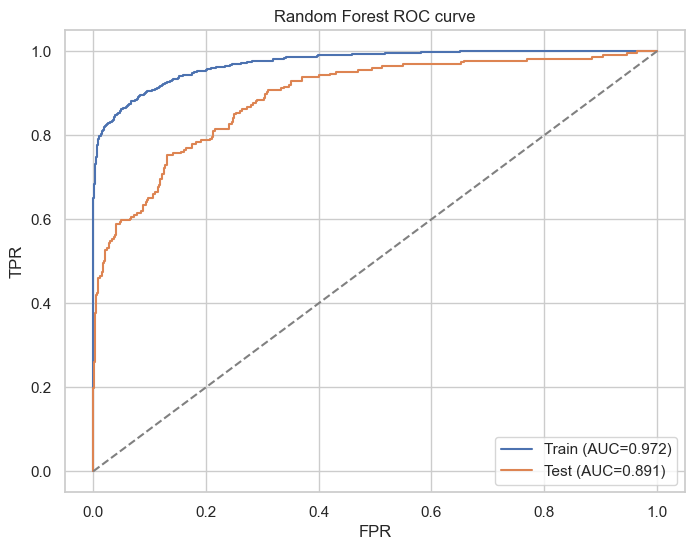

Metrics with Custom Threshold (0.4):
Recall: 0.827
Precision: 0.468
F1 Score: 0.597
ROC AUC: 0.891



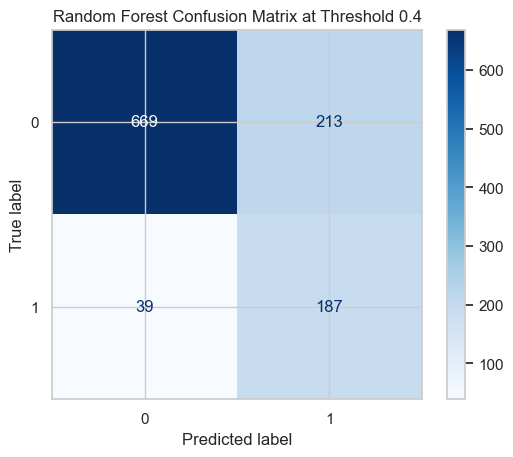

Default and Custom threshold predictions may differ based on threshold logic.


In [245]:
# Définir le modèle
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [140],  # Nombre d'arbres
    'max_depth': [10],       # Profondeur maximale
    'min_samples_split': [10], # Min. échantillons pour division
    'min_samples_leaf': [4],   # Min. échantillons dans une feuille
    'bootstrap': [False]       # Échantillonnage bootstrap
}

# Appeler la fonction
best_rf = train_test_with_cv(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='recall',
    threshold=0.4
)




   Feature  Importance
5   DELINQ    0.141057
6    CLAGE    0.102349
4    DEROG    0.087353
1  MORTDUE    0.072403
0     LOAN    0.068744
7     NINQ    0.063392
3      YOJ    0.045235
2      JOB    0.033808


C:\Users\-\AppData\Local\Temp\ipykernel_67172\4098063429.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=importance_df_top_n, palette='viridis')


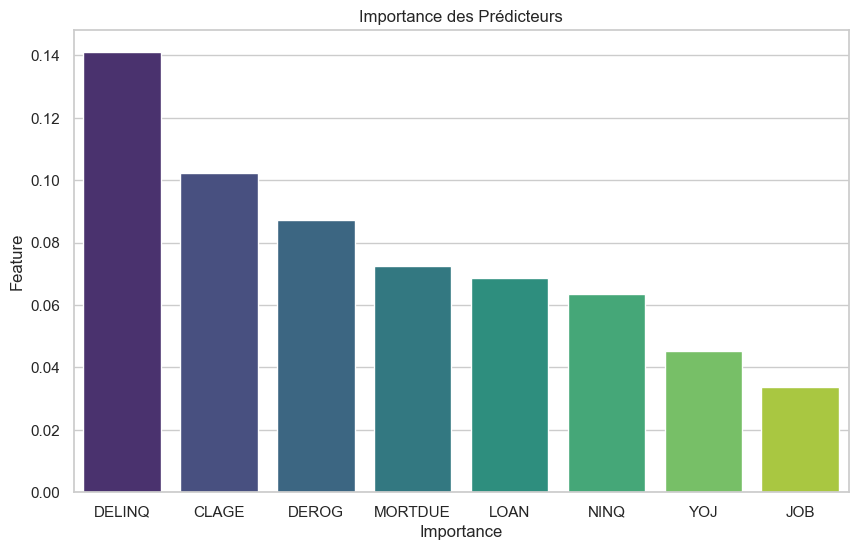

In [230]:
features_importances_model(best_rf, X_train, y_train, X.columns, len(X.columns), True)

## Raw data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Random Forest): {'bootstrap': False, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 45}
Best CV recall Score: 0.635

Class ordering: [0 1]
Random Forest Train AUC: 0.896
Random Forest Train Balanced Acc: 0.827
Random Forest Train Recall: 0.757
Random Forest Test AUC: 0.904
Random Forest Test Balanced Acc: 0.818
Random Forest Test Recall: 0.726



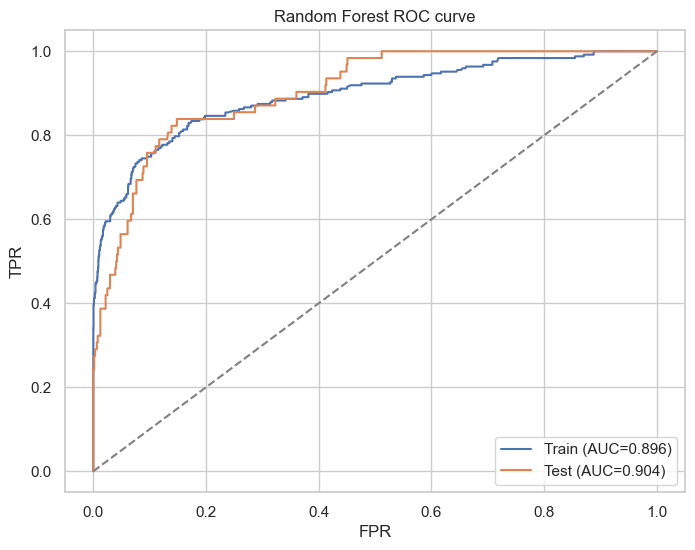

Metrics with Custom Threshold (0.45):
Recall: 0.839
Precision: 0.291
F1 Score: 0.432
ROC AUC: 0.904



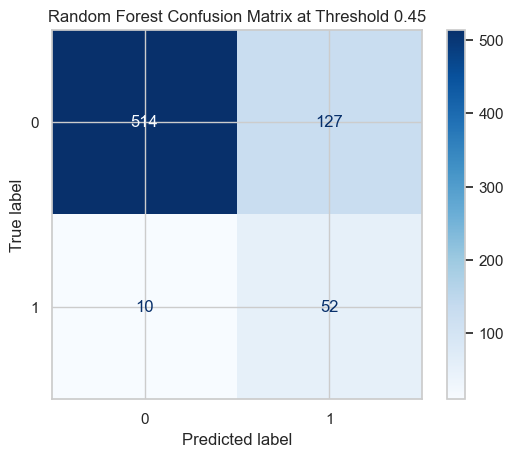

Default and Custom threshold predictions may differ based on threshold logic.


In [231]:
# Définir le modèle
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [45],  # Nombre d'arbres
    'max_depth': [4],       # Profondeur maximale
    'min_samples_split': [2], # Min. échantillons pour division
    'min_samples_leaf': [3],   # Min. échantillons dans une feuille
    'bootstrap': [False]       # Échantillonnage bootstrap
}

# Appeler la fonction
best_rf = train_test_with_cv(
    X_train=X_train_raw,
    y_train=y_train_raw,
    X_test=X_test_raw,
    y_test=y_test_raw,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='recall',
    threshold=0.45

)





# Régression Logistique

## Processed data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Logistic Regression (scaled)): {'logreg__C': 0.001, 'logreg__penalty': 'l2'}
Best CV recall Score: 0.683

Class ordering: [0 1]
Logistic Regression (scaled) Train AUC: 0.765
Logistic Regression (scaled) Train Balanced Acc: 0.704
Logistic Regression (scaled) Train Recall: 0.681
Logistic Regression (scaled) Test AUC: 0.736
Logistic Regression (scaled) Test Balanced Acc: 0.676
Logistic Regression (scaled) Test Recall: 0.642



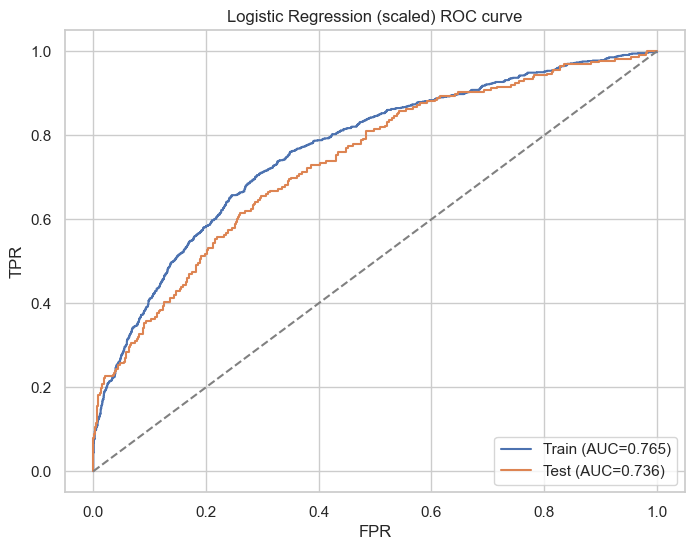

Metrics with Custom Threshold (0.5):
Recall: 0.642
Precision: 0.362
F1 Score: 0.463
ROC AUC: 0.736



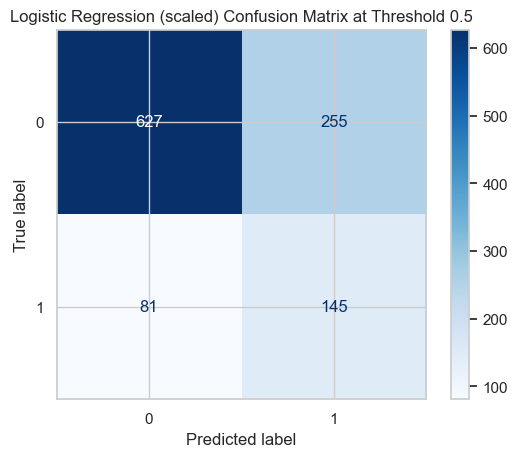

Default Predictions: [1 1 1 0 0 1 1 0 0 1]
Custom Threshold Predictions: [1 1 1 0 0 1 1 0 0 1]
Are they identical? True


In [232]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))
])

param_grid_log = {
    "logreg__C": [0.001],
    "logreg__penalty": ["l2"],
}

best_log = train_test_with_cv(
    model=pipe_log,
    param_grid=param_grid_log,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression (scaled)",
    scoring="recall",
    threshold=0.5
    
)

   Feature  Importance
5   DELINQ    0.056865
4    DEROG    0.029630
6    CLAGE    0.014724
7     NINQ    0.010998
1  MORTDUE    0.001558
0     LOAN    0.001129
2      JOB    0.000497
3      YOJ   -0.004923


C:\Users\-\AppData\Local\Temp\ipykernel_67172\4098063429.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=importance_df_top_n, palette='viridis')


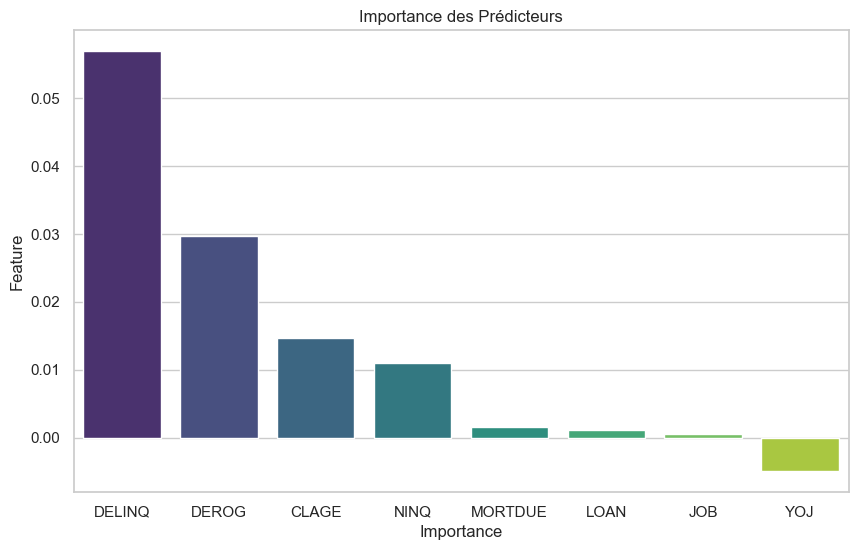

In [233]:
features_importances_model(best_log, X_train, y_train, X.columns, len(X.columns), True)

## Raw data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Logistic Regression (scaled)): {'logreg__C': 0.008, 'logreg__penalty': 'l1'}
Best CV recall Score: 0.733

Class ordering: [0 1]
Logistic Regression (scaled) Train AUC: 0.770
Logistic Regression (scaled) Train Balanced Acc: 0.705
Logistic Regression (scaled) Train Recall: 0.709
Logistic Regression (scaled) Test AUC: 0.778
Logistic Regression (scaled) Test Balanced Acc: 0.722
Logistic Regression (scaled) Test Recall: 0.710



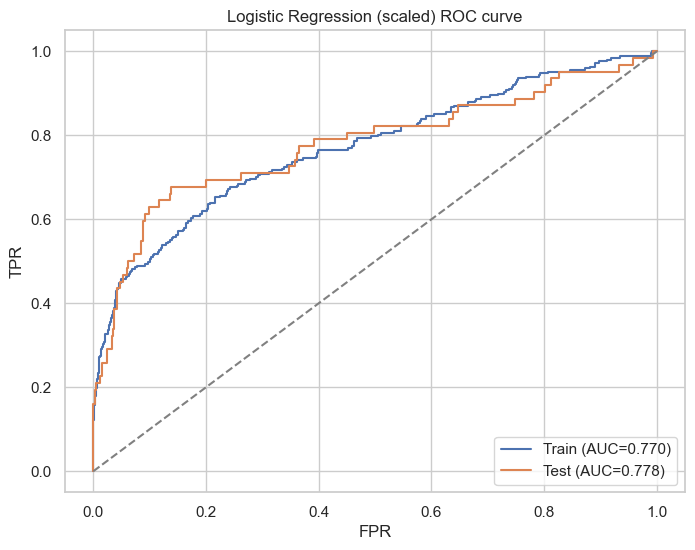

Metrics with Custom Threshold (0.5):
Recall: 0.710
Precision: 0.206
F1 Score: 0.319
ROC AUC: 0.778



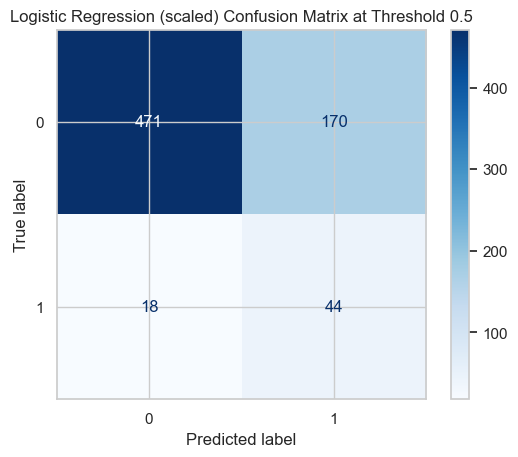

Default Predictions: [0 0 0 0 0 0 0 0 0 0]
Custom Threshold Predictions: [0 0 0 0 0 0 0 0 0 0]
Are they identical? True


In [234]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))
])

param_grid_log = {
    "logreg__C": [0.008],
    "logreg__penalty": ["l1"],
}

best_log = train_test_with_cv(
    model=pipe_log,
    param_grid=param_grid_log,
    X_train=X_train_raw,
    y_train=y_train_raw,
    X_test=X_test_raw,
    y_test=y_test_raw,
    model_name="Logistic Regression (scaled)",
    scoring="recall",  # or "balanced_accuracy"
    threshold=0.5
)   

    Feature  Importance
7    DELINQ    0.027667
11  DEBTINC    0.021053
6     DEROG    0.018314
8     CLAGE    0.008890
0      LOAN    0.000000
1   MORTDUE    0.000000
2     VALUE    0.000000
3    REASON    0.000000
4       JOB    0.000000
5       YOJ    0.000000
10     CLNO    0.000000
9      NINQ   -0.006863


C:\Users\-\AppData\Local\Temp\ipykernel_67172\4098063429.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=importance_df_top_n, palette='viridis')


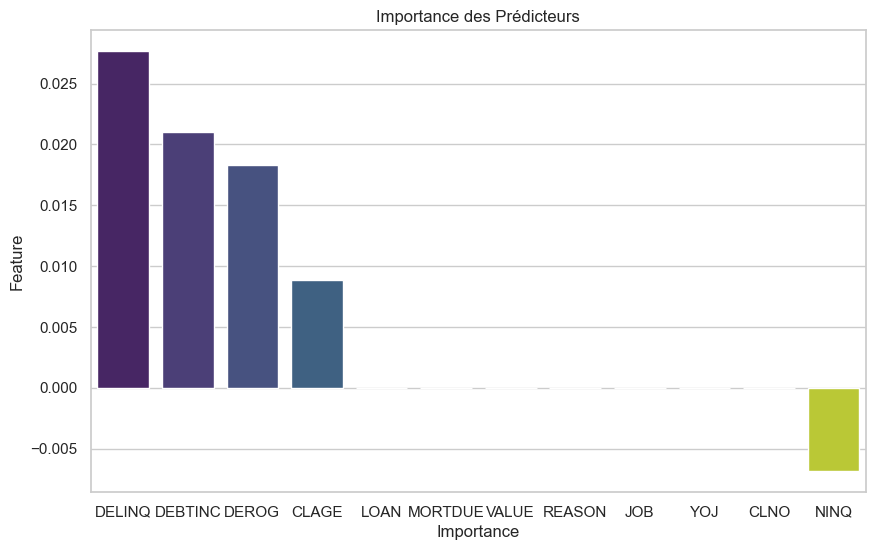

In [235]:
features_importances_model(best_log, X_train_raw, y_train_raw, X_raw.columns, len(X_raw.columns), True)

# SVM (Support Vector Machine)

## Processed data

In [236]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(class_weight="balanced", probability=True, random_state=42))
])

param_grid_svm = {
    "svc__C": [10],
    "svc__kernel": ["rbf"],
    "svc__gamma": ["scale"]
}


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (SVM): {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV recall Score: 0.690

Class ordering: [0 1]
SVM Train AUC: 0.930
SVM Train Balanced Acc: 0.850
SVM Train Recall: 0.802
SVM Test AUC: 0.869
SVM Test Balanced Acc: 0.798
SVM Test Recall: 0.704



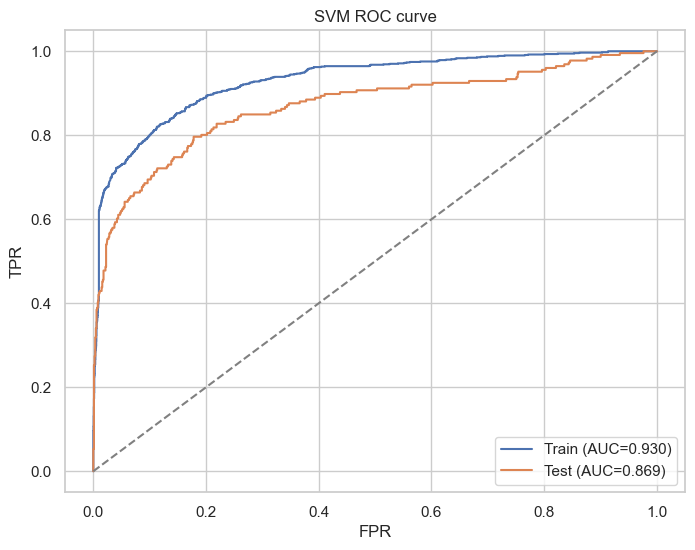

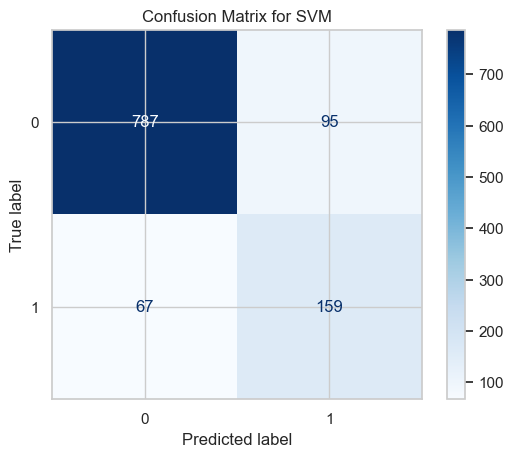

In [237]:
# SVM on the trasnformed data

best_svm = train_test_with_cv(
    model=pipe_svm,
    param_grid=param_grid_svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="SVM",
    scoring="recall",
)

y_test_pred = best_svm.predict(X_test)

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Step 3: Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM")
plt.show()

## RAw data

In [238]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(class_weight="balanced", probability=True, random_state=42))
])

param_grid_svm = {
    "svc__C": [0.5],
    "svc__kernel": ["rbf"],
    "svc__gamma": ["scale", "auto", 0.1, 0.01, 0.001, 0.0001]
}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params (SVM): {'svc__C': 0.5, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV recall Score: 0.652

Class ordering: [0 1]
SVM Train AUC: 0.946
SVM Train Balanced Acc: 0.870
SVM Train Recall: 0.834
SVM Test AUC: 0.900
SVM Test Balanced Acc: 0.800
SVM Test Recall: 0.677



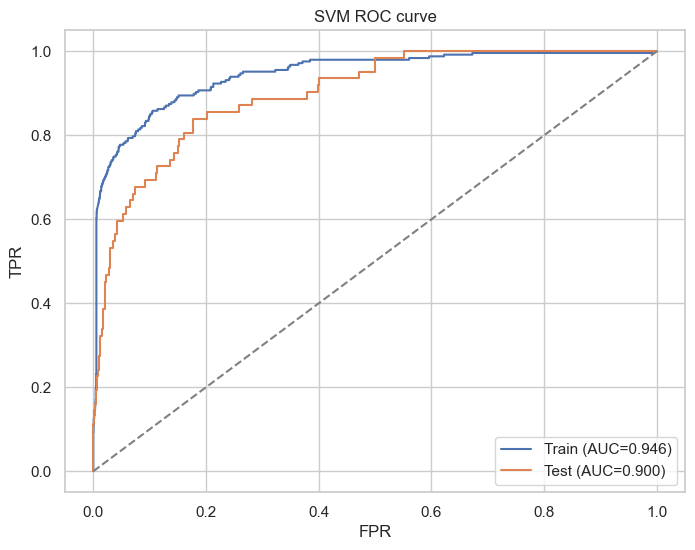

Metrics with Custom Threshold (0.5):
Recall: 0.677
Precision: 0.462
F1 Score: 0.549
ROC AUC: 0.900



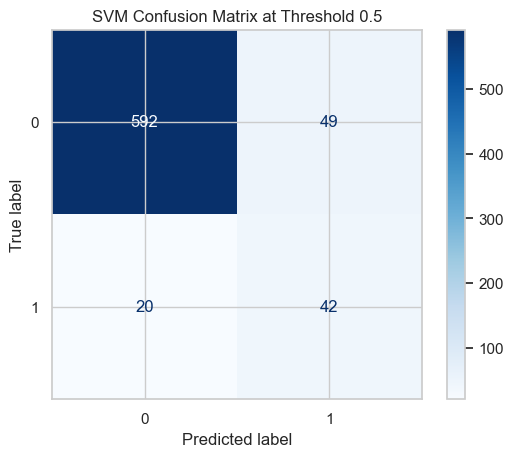

Default Predictions: [0 0 0 0 0 0 0 0 1 0]
Custom Threshold Predictions: [0 0 0 0 0 0 0 0 1 0]
Are they identical? True


In [239]:
best_svm = train_test_with_cv(
    model=pipe_svm,
    param_grid=param_grid_svm,
    X_train=X_train_raw,
    y_train=y_train_raw,
    X_test=X_test_raw,
    y_test=y_test_raw,
    model_name="SVM",
    scoring="recall",
    threshold=0.5
)



    Feature  Importance
11  DEBTINC    0.044986
7    DELINQ    0.042390
9      NINQ    0.036984
6     DEROG    0.029836
1   MORTDUE    0.028912
3    REASON    0.027098
4       JOB    0.022688
10     CLNO    0.017496
5       YOJ    0.015256
8     CLAGE    0.014474
0      LOAN    0.010135
2     VALUE    0.009602


C:\Users\-\AppData\Local\Temp\ipykernel_67172\4098063429.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=importance_df_top_n, palette='viridis')


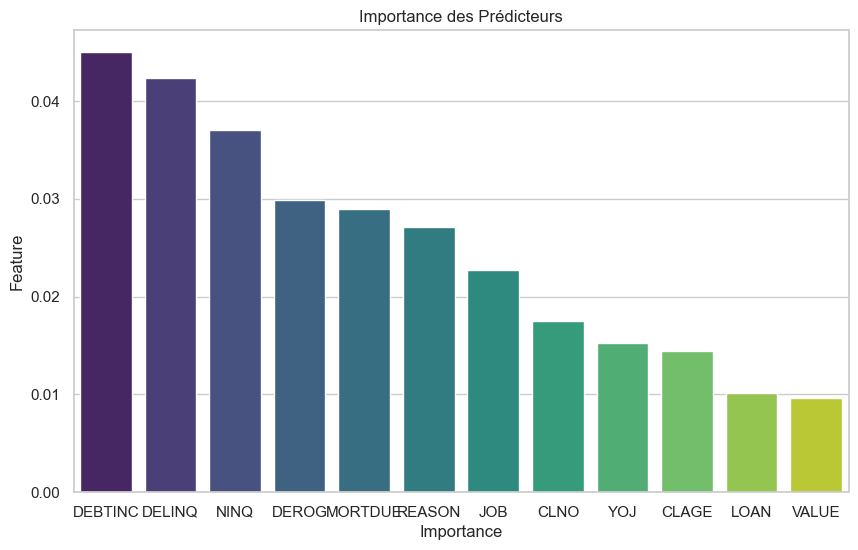

In [240]:
features_importances_model(best_svm, X_train_raw, y_train_raw, X_raw.columns, len(X_raw.columns), True)

# Gradient Boosting

## Processed data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Gradient Boosting (scaled)): {'gb__learning_rate': 0.05, 'gb__max_depth': 6, 'gb__n_estimators': 90, 'gb__subsample': 0.8}
Best CV recall Score: 0.476

Class ordering: [0 1]
Gradient Boosting (scaled) Train AUC: 0.967
Gradient Boosting (scaled) Train Balanced Acc: 0.812
Gradient Boosting (scaled) Train Recall: 0.626
Gradient Boosting (scaled) Test AUC: 0.895
Gradient Boosting (scaled) Test Balanced Acc: 0.732
Gradient Boosting (scaled) Test Recall: 0.478



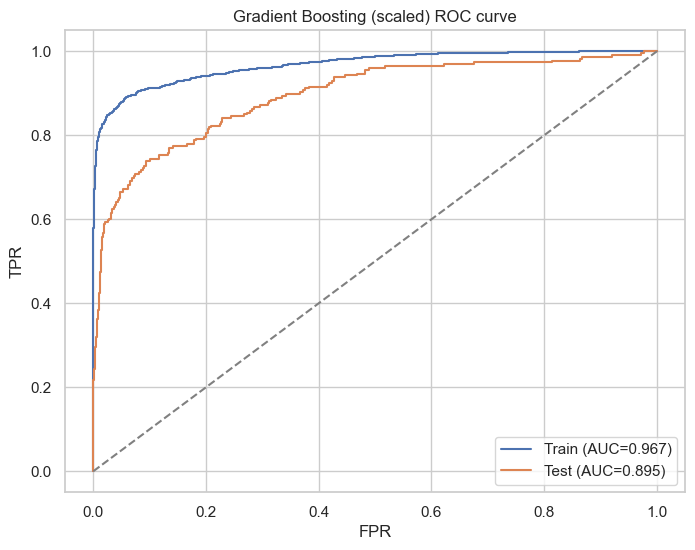

Metrics with Custom Threshold (0.5):
Recall: 0.478
Precision: 0.900
F1 Score: 0.624
ROC AUC: 0.895



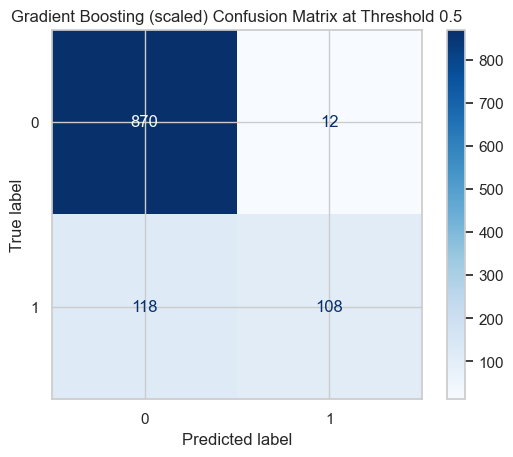

Default Predictions: [0 1 1 0 0 1 1 0 0 0]
Custom Threshold Predictions: [0 1 1 0 0 1 1 0 0 0]
Are they identical? True


In [241]:
# Update pipeline to include sample weights
pipe_gb_with_weights = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state=42))
])


param_grid_gb = {
    "gb__n_estimators": [90],   # Number of trees
    "gb__learning_rate": [0.05],  # Learning rate
    "gb__max_depth": [6],          # Maximum depth of a tree
    "gb__subsample": [0.8],
              # Fraction of samples used per tree
}

# Add class imbalance handling
# GradientBoostingClassifier does not directly support `class_weight`
# Use sample weighting instead if available

# Train the model with cross-validation
best_gb = train_test_with_cv(
    model=pipe_gb_with_weights,
    param_grid=param_grid_gb,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Gradient Boosting (scaled)",
    scoring="recall",
    threshold=0.5

)



## RAw data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Gradient Boosting (scaled)): {'gb__learning_rate': 0.05, 'gb__max_depth': 6, 'gb__n_estimators': 90, 'gb__subsample': 0.9}
Best CV recall Score: 0.441

Class ordering: [0 1]
Gradient Boosting (scaled) Train AUC: 0.998
Gradient Boosting (scaled) Train Balanced Acc: 0.877
Gradient Boosting (scaled) Train Recall: 0.753
Gradient Boosting (scaled) Test AUC: 0.928
Gradient Boosting (scaled) Test Balanced Acc: 0.692
Gradient Boosting (scaled) Test Recall: 0.387



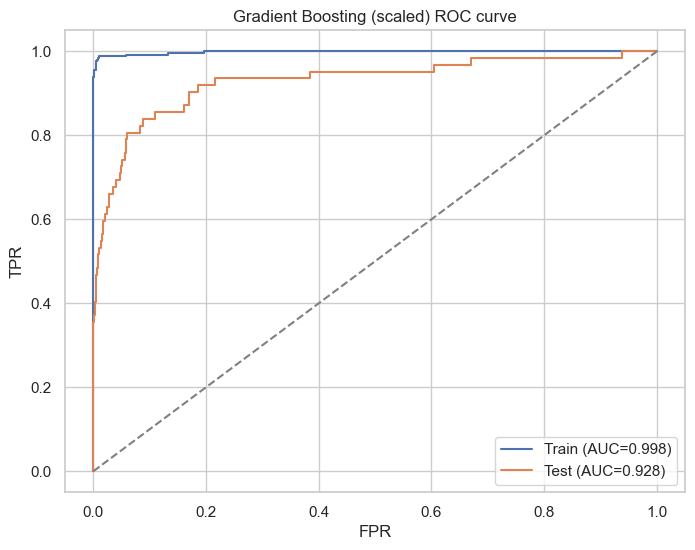

Metrics with Custom Threshold (0.5):
Recall: 0.387
Precision: 0.923
F1 Score: 0.545
ROC AUC: 0.928



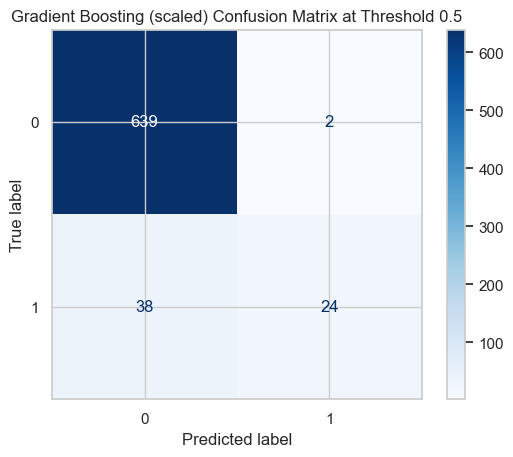

Default Predictions: [0 0 0 0 0 0 0 0 0 0]
Custom Threshold Predictions: [0 0 0 0 0 0 0 0 0 0]
Are they identical? True


In [242]:
# Update pipeline to include sample weights
pipe_gb_with_weights = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid_gb = {
    "gb__n_estimators": [90],   # Number of trees
    "gb__learning_rate": [0.05],  # Learning rate
    "gb__max_depth": [6],          # Maximum depth of a tree
    "gb__subsample": [0.9],
              # Fraction of samples used per tree
}

# Add class imbalance handling
# GradientBoostingClassifier does not directly support `class_weight`
# Use sample weighting instead if available

# Train the model with cross-validation
best_gb = train_test_with_cv(
    model=pipe_gb_with_weights,
    param_grid=param_grid_gb,
    X_train=X_train_raw,
    y_train=y_train_raw,
    X_test=X_test_raw,
    y_test=y_test_raw,
    model_name="Gradient Boosting (scaled)",
    scoring="recall",
    threshold=0.5
)



## Smooth

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best params (Gradient Boosting (scaled)): {'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 46, 'gb__subsample': 0.8}
Best CV recall Score: 0.686

Class ordering: [0 1]
Gradient Boosting (scaled) Train AUC: 0.766
Gradient Boosting (scaled) Train Balanced Acc: 0.711
Gradient Boosting (scaled) Train Recall: 0.720
Gradient Boosting (scaled) Test AUC: 0.732
Gradient Boosting (scaled) Test Balanced Acc: 0.682
Gradient Boosting (scaled) Test Recall: 0.673



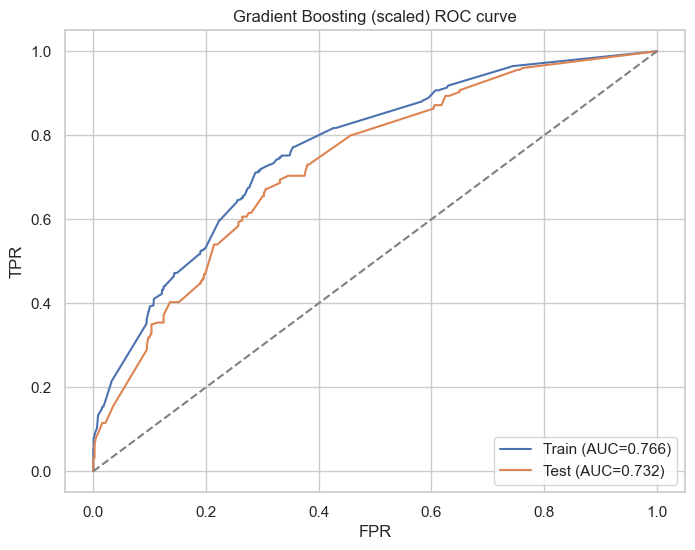

Metrics with Custom Threshold (0.5):
Recall: 0.673
Precision: 0.358
F1 Score: 0.468
ROC AUC: 0.732



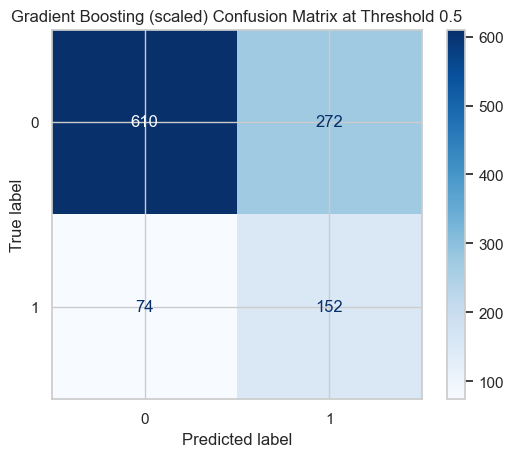

Default Predictions: [0 1 1 0 0 1 1 0 1 1]
Custom Threshold Predictions: [0 1 1 0 0 1 1 0 1 1]
Are they identical? True


In [243]:

# Update pipeline to include sample weights
pipe_gb_with_weights = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("gb", GradientBoostingClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid_gb = {
    "gb__n_estimators": [46],   # Number of trees
    "gb__learning_rate": [0.01],  # Learning rate
    "gb__max_depth": [3],          # Maximum depth of a tree
    "gb__subsample": [0.8],
              # Fraction of samples used per tree
}

# Add class imbalance handling
# GradientBoostingClassifier does not directly support `class_weight`
# Use sample weighting instead if available

# Train the model with cross-validation
best_gb = train_test_with_cv(
    model=pipe_gb_with_weights,
    param_grid=param_grid_gb,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Gradient Boosting (scaled)",
    scoring="recall",
    threshold=0.5
)
